In [1]:
from    copy                 import deepcopy
from    datetime             import datetime
from    itertools            import chain
import  cmath 
import  math                 as     mt
import  matplotlib.pyplot    as     plt
import  networkx             as     nx
import  numpy                as     np
import  os
import  pandas               as     pd
import  pandapower           as     pp
import  pypsa                as     pys
from    random               import uniform
from    scipy.interpolate    import griddata
from    scipy.optimize       import minimize, least_squares
from    scipy.sparse         import csr_matrix
import  sys
import  time                 as     tm



c:\Users\HP\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
c:\Users\HP\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
c:\Users\HP\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


In [2]:
# Set a Element Class that is common to all the elements in the grid

class Node():
    def __init__(self, node_number, node_name, vn_kv, elec_type):
        self.node_number = node_number
        self.node_name = node_name
        self.vn_kv = vn_kv
        self.elec_type = elec_type

class Line():
    def __init__(self, from_bus, to_bus, line_id, l_km, r_ohm_km, x_ohm_km, c_ohm_km, Imax_kA):
        self.from_bus = from_bus
        self.to_bus = to_bus
        self.line_id = line_id
        self.l_km = l_km
        self.r_ohm_km = r_ohm_km
        self.x_ohm_km = x_ohm_km
        self.c_ohm_km = c_ohm_km
        self.Imax_kA = Imax_kA
        
class Transformer():
    def __init__(self, from_bus, to_bus, trafo_id, sn, vk_percent, vkr_percent, pfe_kw, i0_percent, shift_degree, vector_group, tap_side, min_tap, max_tap, tap_step_degree, tap_step, tap_ps, vk0_percent, vkr0_percent, mag0_percent, mag0_rx, si0_hv_partial):
        self.from_bus = from_bus
        self.to_bus = to_bus
        self.trafo_id = trafo_id
        self.sn = sn
        self.vk_percent = vk_percent
        self.vkr_percent = vkr_percent
        self.pfe_kw = pfe_kw
        self.i0_percent = i0_percent
        self.shift_degree = shift_degree
        self.vector_group = vector_group
        self.tap_side = tap_side
        self.min_tap = min_tap
        self.max_tap = max_tap
        self.tap_step_degree = tap_step_degree
        self.tap_step = tap_step
        self.tap_ps = tap_ps
        self.vk0_percent = vk_percent
        self.vkr0_percent = vkr_percent
        self.mag0_percent = i0_percent
        self.mag0_rx = mag0_rx
        self.si0_hv_partial = si0_hv_partial

class Converter():
    def __init__(self, from_bus, to_bus, conv_id, convtype, pn, r_ohm, x_ohm, r_dc_ohm, pl_dc_kw, control_mode, control_value, eff_table):
        self.from_bus = from_bus
        self.to_bus = to_bus
        self.conv_id = conv_id
        self.convtype = convtype
        self.pn = pn
        self.r_ohm = r_ohm
        self.x_ohm = x_ohm
        self.pl_dc_kw = pl_dc_kw
        self.control_mode = control_mode
        self.control_value = control_value
        self.eff_table = eff_table
        

class Elem:
    def __init__(self, owner, bus):
        self.owner = owner
        self.bus = bus

class Load(Elem):
    def __init__(self, owner, bus, load_id, ctype, dp_cont, vn, pn, droop):
        super().__init__(owner, bus)
        self.load_id = load_id
        self.ctype = ctype
        self.dp_cont = dp_cont
        self.vn = vn
        self.pn = pn
        self.droop = droop


class Gen(Elem):
    def __init__(self, owner, bus, gen_id, gentype, dp_cont, vn, pn, droop):
        super().__init__(owner, bus)
        self.gen_id = gen_id
        self.gentype = gentype
        self.dp_cont = dp_cont
        self.vn = vn
        self.pn = pn
        self.droop = droop

class Stor(Elem):
    def __init__(self, owner, bus, stor_id, stortype, dp_cont, ini_SOC, vn, pn, max_ener, max_p_discharge, max_p_charge, max_SOC, min_SOC, droop):
        super().__init__(owner, bus)
        self.stor_id = stor_id
        self.stortype = stortype
        self.dp_cont = dp_cont
        self.ini_SOC = ini_SOC
        self.vn = vn
        self.pn = pn
        self.max_ener = max_ener
        self.max_p_discharge = max_p_discharge
        self.max_p_charge = max_p_charge
        self.max_SOC = max_SOC
        self.min_SOC = min_SOC
        self.droop = droop


In [3]:
# Read the Excel file

def load_Excel_file(file_path): # Improvement (Consider reading other type of format input file open source as json or parquet)
    
    # Read Excel data
    print(">Read the Excel file")
    
    xl_file = pd.ExcelFile(file_path)

    # Load data from Excel sheets
    print(">Load data from Excel sheets")
    
    netdata = {
        'general_data': xl_file.parse('GeneralInfo'),
        'node_data': xl_file.parse('NodeInfo'),
        'line_data': xl_file.parse('LineInfo'),
        'transformer_data': xl_file.parse('TransformerInfo'),
        'converter_data': xl_file.parse('ConverterInfo'),
        'load_data': xl_file.parse('LoadInfo', header=0),
        'gen_data': xl_file.parse('GenInfo', header=0),
        'stor_data': xl_file.parse('StorInfo', header=0)
    }

    return netdata

netdata = load_Excel_file('C:/Users/HP/Desktop/Engenharia Eletrotécnica/Doutoramento/1º Ano/Tese/Modelação/Redes de teste/grid_v10.xlsx')

>Read the Excel file
>Load data from Excel sheets


In [ ]:
# Grid data for time variant PF -> Creation of the main tables of network data

def internal_management_data(netdata):

    ## GENERAL DATA

    # Using a variable to access easily to the information

    general_data = netdata['general_data']

    # Ensure the column names match exactly and there is no leading/trailing whitespace
    
    general_data.columns = general_data.columns.str.strip()
    
    # Define the base voltage and power from the baseValue sheet

    sim_periods = general_data[general_data['General Information'].str.strip() == 'Simulation Periods']['Value']
    period_duration = general_data[general_data['General Information'].str.strip() == 'Periods Duration (h)']['Value']
    base_power = general_data[general_data['General Information'].str.strip() == 'Base Power (kW)']['Value']
    slack_comp = general_data[general_data['General Information'].str.strip() == 'Slack Gen Component']['Value']

    if sim_periods.empty:
        raise ValueError("The value of Number of Periods is missing.")
    elif period_duration.empty:
        raise ValueError("The value of Period Duration is missing.")
    elif base_power.empty:
        raise ValueError("Base value for Power is missing.")
    elif slack_comp.empty:
        raise ValueError("The value of Slack Component is missing.")

    base_power_kW = base_power.item()

    ## NODES

    # Using a variable to access easily to the information

    node_data = netdata['node_data']

    # List of nodes to make easier access to the information

    Nodelist = [Node(0, i, 0, 0) for i in node_data['Name']]

    for i in range(len(Nodelist)): 

        # Finding the index corresponding to node name
        
        j = node_data[node_data['Name'] == Nodelist[i].node_name].index[0]

        # Giving the information of the nodes to Nodelist

        Nodelist[i].node_number = node_data.at[j, 'Node Number']
        Nodelist[i].node_name = node_data.at[j, 'Name']
        Nodelist[i].vn_kv = node_data.at[j, 'Vn (kV)']
        Nodelist[i].elec_type = node_data.at[j, 'Type']


    #Nodelist = [Node(0,i,0,0) for i in node_data['Name']]

    #for i in range(0,len(Nodelist)): 
        
    #    j = node_data.index[Nodelist[i].node_name == node_data['Name']]

    #    Nodelist[i].node_number = node_data['Node Number'].iloc[j]
    
    #    Nodelist[i].node_name = node_data['Name'].iloc[j]       
    
    #    Nodelist[i].vn_kv = node_data['Vn (kV)'].iloc[j]
    
    #    Nodelist[i].elec_type = node_data['Type'].iloc[j]

    ### NETWORK EQUIPMENT

    ## LINES

    # Using a variable to access easily to the information

    line_data = netdata['line_data']

    # List of lines to make easier access to the information

    Linelist = [Line(0, 0, i, 0, 0, 0, 0, 0) for i in line_data['Component']]

    for i in range(len(Linelist)): 

        # Finding the index corresponding to line name

        j = line_data[line_data['Component'] == Linelist[i].line_id].index[0]

        # Giving the information of the lines to Linelist

        Linelist[i].from_bus = line_data.at[j, 'Node_i']
        Linelist[i].to_bus = line_data.at[j, 'Node_j']
        Linelist[i].l_km = line_data.at[j, 'Length_ij_km']
        Linelist[i].r_ohm_km = line_data.at[j, 'Rij_ohm_km']
        Linelist[i].x_ohm_km = line_data.at[j, 'Xij_ohm_km']
        Linelist[i].c_ohm_km = line_data.at[j, 'Cij_ohm_km']
        Linelist[i].Imax_kA = line_data.at[j, 'Imax_ij_kA'] 
        
    # Transformer equipment

    ## Transformer equipment

    # Using a variable to access easily to the information

    transformer_data = netdata['transformer_data']

    # Verify if the 'transformer_data' contains data

    if 'Component' in transformer_data.columns and not transformer_data.empty:

        # List of transformers to make easier access to the information

        Trafolist = [Transformer(0, 0, i, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0) for i in transformer_data['Component']]

        for i in range(len(Trafolist)):  

            # Finding the index corresponding to line name
            
            j = transformer_data[transformer_data['Component'] == Trafolist[i].trafo_id].index[0]

            # Filling the transformer attributes with data

            Trafolist[i].from_bus = transformer_data.at[j, 'Node_i']
            Trafolist[i].to_bus = transformer_data.at[j, 'Node_j']
            Trafolist[i].sn = transformer_data.at[j, 'Sn (MVA)']
            Trafolist[i].vk_percent = transformer_data.at[j, 'Short-circuit voltage (pu)']
            Trafolist[i].vkr_percent = transformer_data.at[j, 'Resistive part of Short-circuit voltage (pu)']
            Trafolist[i].pfe_kw = transformer_data.at[j, 'Iron losses (kW)']
            Trafolist[i].i0_percent = transformer_data.at[j, 'Magnetization Current (pu)']
            Trafolist[i].shift_degree = transformer_data.at[j, 'Shift degree']
            Trafolist[i].vector_group = transformer_data.at[j, 'Vector Group']
            Trafolist[i].tap_side = transformer_data.at[j, 'Tap Side']
            Trafolist[i].min_tap = transformer_data.at[j, 'Minimal Tap']
            Trafolist[i].max_tap = transformer_data.at[j, 'Maximum Tap']
            Trafolist[i].tap_step_degree = transformer_data.at[j, 'Tap step degree']
            Trafolist[i].tap_step = transformer_data.at[j, 'Tap step (%)']
            Trafolist[i].tap_ps = transformer_data.at[j, 'Tap Phase Shifter']
            Trafolist[i].vk0_percent = transformer_data.at[j, 'Zero sequence short-circuit voltage (pu)']
            Trafolist[i].vk0r_percent = transformer_data.at[j, 'Zero sequence resistive part of short-circuit voltage (pu)']
            Trafolist[i].mag0_percent = transformer_data.at[j, 'Zero sequence of magnetization current (pu)']
            Trafolist[i].mag0_rx = transformer_data.at[j, 'Ratio R/X of Zero sequence of Magnetization Current']
            Trafolist[i].si0_hv_partial = transformer_data.at[j, 'Zero sequence short-circuit impedance distribution in HV side']

    else:

        Trafolist = []  # It is treated as an empty list instead of null variable since the DC/DC converter model consists in transformer model
        #print("Warning: No transformer data found in the provided Excel file.")


    # Converter equipment 

    # Using a variable to access easily to the information

    converter_data = netdata['converter_data']

    for col in converter_data.columns:
        if converter_data[col].str.contains('Component', na=False).any():  # Verifies where "Component" exists
            component_column = col
            component_row = converter_data[converter_data[col].str.contains('Component', na=False)].index[0]
            break

    values_below = converter_data[component_column].iloc[component_row + 1:]  # Values below "Component"
    
    # Check if there is any numeric value below
    has_numeric_values = values_below.apply(lambda x: isinstance(x, (int, float)) and pd.notnull(x)).any()

    # Check if converter data exists in Excel file
    if has_numeric_values:
        
        # Processing of converter data
        convCarac = converter_data[['Converter ID','Unnamed: 1','Unnamed: 2','Unnamed: 3']]
        convCarac = convCarac.rename(columns={
            'Converter ID': convCarac['Converter ID'][0],
            'Unnamed: 1': convCarac['Unnamed: 1'][0],
            'Unnamed: 2': convCarac['Unnamed: 2'][0],
            'Unnamed: 3': convCarac['Unnamed: 3'][0]
        })
        convCarac = convCarac[1:]
        convCarac.index = range(0, len(convCarac['Component']))

        # Clean empty data
        aux_idx = []
        for i, _ in enumerate(convCarac.iterrows()):
            if pd.isna(convCarac.iloc[i]).all():
                aux_idx.append(i)
        convCarac = convCarac.drop(aux_idx)
        convCarac.index = range(0, convCarac.shape[0])

        # Create DataFrame with the característics of converters
        nConvCarac = pd.DataFrame([convCarac['Characteristics ID'].iloc[idx] for idx, _ in enumerate(convCarac['Characteristics ID']) if idx+1 not in convCarac['Characteristics ID'] or type(convCarac['Component'].iloc[idx+1]) is int], index=convCarac['Component'].dropna().unique(), columns=['Number Caracteristics'])

        # Create the list of converters
        Convlist = [Converter(0, 0, i, 0, 0, 0, 0, 0, 0, 0, 0, 0) for i in nConvCarac.index]
        
        aux_nConvCarac = pd.DataFrame(np.cumsum(nConvCarac.values), index=nConvCarac.index)
        
        # Get the columns relative to the converters
        pos_Comp = np.asarray(np.where(converter_data == 'Component'))
        pos_EffCurve = np.asarray(np.where(converter_data == 'Efficiency Curve'))
        
        # Processing the característics of converters
        for i in nConvCarac.index:
            if i-1 not in nConvCarac.index:
                j = 0
                jlim = (aux_nConvCarac.loc[i].values - 1).item()
                while j <= jlim:
                    if convCarac['Characteristics D.'].iloc[j] == 'From Bus':
                        Convlist[i-1].from_bus = convCarac['Characteristics V.'].iloc[j]
                    elif convCarac['Characteristics D.'].iloc[j] == 'To Bus':
                        Convlist[i-1].to_bus = convCarac['Characteristics V.'].iloc[j]
                    elif convCarac['Characteristics D.'].iloc[j] == 'Converter Type':                   
                        Convlist[i-1].convtype = convCarac['Characteristics V.'].iloc[j]    
                        j_aux = 0
                        if Convlist[i-1].convtype == 'Converter AC/DC' or Convlist[i-1].convtype == 'Converter DC/DC':
                            while j_aux <= jlim:
                                if convCarac['Characteristics D.'].iloc[j_aux] == 'Transformer Resistance (Ohm)':
                                    Convlist[i-1].r_ohm = convCarac['Characteristics V.'].iloc[j_aux]
                                elif convCarac['Characteristics D.'].iloc[j_aux] == 'Transformer Reactance (Ohm)':
                                    Convlist[i-1].x_ohm = convCarac['Characteristics V.'].iloc[j_aux]
                                elif convCarac['Characteristics D.'].iloc[j_aux] == 'No-Load DC Power Losses (kW)':                   
                                    Convlist[i-1].pl_dc_kw = convCarac['Characteristics V.'].iloc[j_aux]    
                                elif convCarac['Characteristics D.'].iloc[j_aux] == 'Control Mode':                   
                                    Convlist[i-1].control_mode = convCarac['Characteristics V.'].iloc[j_aux] 
                                elif convCarac['Characteristics D.'].iloc[j_aux] == 'Control Value':                   
                                    Convlist[i-1].control_value = convCarac['Characteristics V.'].iloc[j_aux] 
                                j_aux += 1
                    elif convCarac['Characteristics D.'].iloc[j] == 'Nominal Power (kW)':
                        Convlist[i-1].pn = convCarac['Characteristics V.'].iloc[j]
                    j += 1
            else:
                j = (aux_nConvCarac.loc[i-1].values).item()
                jlim = (aux_nConvCarac.loc[i].values - 1).item()
                while j <= jlim:
                    if convCarac['Characteristics D.'].iloc[j] == 'From Bus':
                        Convlist[i-1].from_bus = convCarac['Characteristics V.'].iloc[j]
                    elif convCarac['Characteristics D.'].iloc[j] == 'To Bus':
                        Convlist[i-1].to_bus = convCarac['Characteristics V.'].iloc[j]
                    elif convCarac['Characteristics D.'].iloc[j] == 'Converter Type':                   
                        Convlist[i-1].convtype = convCarac['Characteristics V.'].iloc[j]    
                        j_aux = 0
                        if Convlist[i-1].convtype == 'Converter AC/DC' or Convlist[i-1].convtype == 'Converter DC/DC':
                            while j_aux <= jlim:
                                if convCarac['Characteristics D.'].iloc[j_aux] == 'Transformer Resistance (Ohm)':
                                    Convlist[i-1].r_ohm = convCarac['Characteristics V.'].iloc[j_aux]
                                elif convCarac['Characteristics D.'].iloc[j_aux] == 'Transformer Reactance (Ohm)':
                                    Convlist[i-1].x_ohm = convCarac['Characteristics V.'].iloc[j_aux]
                                elif convCarac['Characteristics D.'].iloc[j_aux] == 'No-Load DC Power Losses (kW)':                   
                                    Convlist[i-1].pl_dc_kw = convCarac['Characteristics V.'].iloc[j_aux]    
                                elif convCarac['Characteristics D.'].iloc[j_aux] == 'Control Mode':                   
                                    Convlist[i-1].control_mode = convCarac['Characteristics V.'].iloc[j_aux] 
                                elif convCarac['Characteristics D.'].iloc[j_aux] == 'Control Value':                   
                                    Convlist[i-1].control_value = convCarac['Characteristics V.'].iloc[j_aux] 
                                j_aux += 1
                    elif convCarac['Characteristics D.'].iloc[j] == 'Nominal Power (kW)':
                        Convlist[i-1].pn = convCarac['Characteristics V.'].iloc[j]
                    j += 1

        # Get the map of efficiency
        convEff = converter_data[converter_data.columns[int(pos_EffCurve[1]):]]
        convEff.insert(0, converter_data.columns[int(pos_Comp[1])], converter_data[converter_data.columns[int(pos_Comp[1])]])
        convEff.columns = convEff.iloc[0,:]   
        convEff = convEff[1:]  
        convEff.index = range(0, convEff.shape[0])
        aux_PF = convEff['Efficiency Curve'].dropna().unique()

        for i in range(0, len(Convlist)):
            ji = convEff.index[convEff['Component'] == (i + 1)].item()
            jf = ji + len(aux_PF)
            Convlist[i].eff_table = convEff.iloc[ji:jf, 1:].dropna()

    else:
        # If does not exists converters, Convlist is an empty list
        Convlist = []

    # LOADS 

    # Get the caracteristics of the load components in grid from load_data

    load_data = netdata['load_data']

    for col in load_data.columns:
        if load_data[col].str.contains('Component', na=False).any():  # Verifies where "Component" exists
            component_column = col
            component_row = load_data[load_data[col].str.contains('Component', na=False)].index[0]
            break

    values_below = load_data[component_column].iloc[component_row + 1:]  # Values below "Component"
    
    # Check if there is any numeric value below
    has_numeric_values = values_below.apply(lambda x: isinstance(x, (int, float)) and pd.notnull(x)).any()

    # Confirm if exists load data in input file
    if has_numeric_values:
        
        loadCarac = load_data[['Load ID','Unnamed: 1','Unnamed: 2','Unnamed: 3']]
        loadCarac = loadCarac.rename(columns={
            'Load ID': loadCarac['Load ID'][1],
            'Unnamed: 1': loadCarac['Unnamed: 1'][1],
            'Unnamed: 2': loadCarac['Unnamed: 2'][1],
            'Unnamed: 3': loadCarac['Unnamed: 3'][1]
        })
        loadCarac = loadCarac[2:]
        loadCarac.index = range(0, len(loadCarac['Component']))

        aux_idx = []
        for i, _ in enumerate(loadCarac.iterrows()):
            if pd.isna(loadCarac.iloc[i]).all():
                aux_idx.append(i)
        loadCarac = loadCarac.drop(aux_idx)
        loadCarac.index = range(0, loadCarac.shape[0])

        nLoadCarac = pd.DataFrame([loadCarac['Characteristics ID'].iloc[idx] for idx, _ in enumerate(loadCarac['Characteristics ID']) if idx+1 not in loadCarac['Characteristics ID'] or type(loadCarac['Component'].iloc[idx+1]) is int], index=loadCarac['Component'].dropna().unique(), columns=['Number Caracteristics'])
        
        Loadlist = [Load(0, 0, i, 0, 0, 0, 0, 0) for i in nLoadCarac.index]
        
        aux_nLoadCarac = pd.DataFrame(np.cumsum(nLoadCarac.values), index=nLoadCarac.index)
        
        for i in nLoadCarac.index:
            if i-1 not in nLoadCarac.index:
                j = 0
                jlim = (aux_nLoadCarac.loc[i].values - 1).item()
                while j <= jlim:
                    if loadCarac['Characteristics D.'].iloc[j] == 'Bus Location':
                        Loadlist[i-1].bus = loadCarac['Characteristics V.'].iloc[j]
                    elif loadCarac['Characteristics D.'].iloc[j] == 'Droop Contribution':
                        Loadlist[i-1].dp_cont = loadCarac['Characteristics V.'].iloc[j]
                    elif loadCarac['Characteristics D.'].iloc[j] == 'Charge Type':                   
                        Loadlist[i-1].ctype = loadCarac['Characteristics V.'].iloc[j]                      
                    elif loadCarac['Characteristics D.'].iloc[j] == 'Nominal Voltage (V)':
                        Loadlist[i-1].vn = loadCarac['Characteristics V.'].iloc[j]
                    elif loadCarac['Characteristics D.'].iloc[j] == 'Nominal Power (kW)':
                        Loadlist[i-1].pn = loadCarac['Characteristics V.'].iloc[j]
                    j += 1
            else:
                j = (aux_nLoadCarac.loc[i-1].values).item()
                jlim = (aux_nLoadCarac.loc[i].values - 1).item()
                while j <= jlim:
                    if loadCarac['Characteristics D.'].iloc[j] == 'Bus Location':
                        Loadlist[i-1].bus = loadCarac['Characteristics V.'].iloc[j]
                    elif loadCarac['Characteristics D.'].iloc[j] == 'Droop Contribution':
                        Loadlist[i-1].dp_cont = loadCarac['Characteristics V.'].iloc[j]
                    elif loadCarac['Characteristics D.'].iloc[j] == 'Charge Type':                   
                        Loadlist[i-1].ctype = loadCarac['Characteristics V.'].iloc[j]                      
                    elif loadCarac['Characteristics D.'].iloc[j] == 'Nominal Voltage (V)':
                        Loadlist[i-1].vn = loadCarac['Characteristics V.'].iloc[j]
                    elif loadCarac['Characteristics D.'].iloc[j] == 'Nominal Power (kW)':
                        Loadlist[i-1].pn = loadCarac['Characteristics V.'].iloc[j]
                    j += 1

        aux_namCol = ['Load ID', 'Unnamed: 4', 'Total Time (h)']
        for i, j in enumerate(load_data.columns):
            if type(j) is int:                       
                aux_namCol.append(j)
        
        loadDroop = load_data[aux_namCol]
        loadDroop = loadDroop.rename(columns={
            'Load ID': loadDroop['Load ID'][1],
            'Unnamed: 4': loadDroop['Unnamed: 4'][1],
            'Total Time (h)': loadDroop['Total Time (h)'][1]
        })
        loadDroop = loadDroop[2:]
        maxDroopsLoad = max(loadDroop['Droop ID'].unique())
        loadDroop.index = range(0, loadDroop.shape[0])

        for i in nLoadCarac.index:
            aux_indx = (np.array(loadDroop.index[loadDroop['Component'] == i].tolist())).item()
            if aux_indx is not None:
                for j in range(0, len(Loadlist)):
                    if Loadlist[j].load_id == i:
                        Loadlist[j].droop = loadDroop.loc[aux_indx:aux_indx + maxDroopsLoad - 1]

        for i in range(0, len(Loadlist)):
            auxV = pd.DataFrame(Loadlist[i].droop.loc[Loadlist[i].droop.index[Loadlist[i].droop['Droop'].str.contains('V')], 'Droop'], index=Loadlist[i].droop.index[Loadlist[i].droop['Droop'].str.contains('V')].tolist())
            auxV.sort_values(by='Droop')

            auxP = pd.DataFrame(Loadlist[i].droop.loc[Loadlist[i].droop.index[Loadlist[i].droop['Droop'].str.contains(r'P\d+', regex=True)], 'Droop'], index=Loadlist[i].droop.index[Loadlist[i].droop['Droop'].str.contains(r'P\d+', regex=True)].tolist())
            auxP.sort_values(by='Droop')

            auxVP = list(zip(auxV.index, auxP.index))

            for k in Loadlist[i].droop.columns:
                if type(k) is int:
                    droop_list = []
                    for j, _ in enumerate(auxVP): 
                        droop_list.append(Loadlist[i].droop.loc[np.array(list(auxVP[j])), k].values)  
                    df = pd.DataFrame(droop_list, columns=['x', 'y'])
                    df_sorted = df.sort_values(by=['x', 'y'])
                    Loadlist[i].droop.loc[auxV.index, k] = df_sorted['x'].values
                    Loadlist[i].droop.loc[auxP.index, k] = df_sorted['y'].values

    else:

        Loadlist = []


    # GENERATORS
    
    # Get the caracteristics of the generators components in grid from gen_data

    gen_data = netdata['gen_data']

    for col in gen_data.columns:
        if gen_data[col].str.contains('Component', na=False).any():  
            component_column = col
            component_row = gen_data[gen_data[col].str.contains('Component', na=False)].index[0]
            break

    values_below = gen_data[component_column].iloc[component_row + 1:]  
    
    has_numeric_values = values_below.apply(lambda x: isinstance(x, (int, float)) and pd.notnull(x)).any()

    if has_numeric_values:
        
        genCarac = gen_data[['Gen ID', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3']]
        genCarac = genCarac.rename(columns={
            'Gen ID': genCarac['Gen ID'][1],
            'Unnamed: 1': genCarac['Unnamed: 1'][1],
            'Unnamed: 2': genCarac['Unnamed: 2'][1],
            'Unnamed: 3': genCarac['Unnamed: 3'][1]
        })
        genCarac = genCarac[2:]
        genCarac.index = range(0, len(genCarac['Component']))

        aux_idx = []
        for i, _ in enumerate(genCarac.iterrows()):
            if pd.isna(genCarac.iloc[i]).all():
                aux_idx.append(i)
        genCarac = genCarac.drop(aux_idx)
        genCarac.index = range(0, genCarac.shape[0])

        nGenCarac = pd.DataFrame([genCarac['Characteristics ID'].iloc[idx] for idx, _ in enumerate(genCarac['Characteristics ID']) if idx + 1 not in genCarac['Characteristics ID'] or type(genCarac['Component'].iloc[idx + 1]) is int], index=genCarac['Component'].dropna().unique(), columns=['Number Caracteristics'])
        
        Genlist = [Gen(0, 0, i, 0, 0, 0, 0, 0) for i in nGenCarac.index]
        
        aux_nGenCarac = pd.DataFrame(np.cumsum(nGenCarac.values), index=nGenCarac.index)
        
        for i in nGenCarac.index:
            if i - 1 not in nGenCarac.index:
                j = 0
                jlim = (aux_nGenCarac.loc[i].values - 1).item()
                while j <= jlim:
                    if genCarac['Characteristics D.'].iloc[j] == 'Bus Location':
                        Genlist[int(i - 1)].bus = genCarac['Characteristics V.'].iloc[j]
                    elif genCarac['Characteristics D.'].iloc[j] == 'Droop Contribution':
                        Genlist[int(i - 1)].dp_cont = genCarac['Characteristics V.'].iloc[j]
                    elif genCarac['Characteristics D.'].iloc[j] == 'Gen Type':                    
                        Genlist[i - 1].gentype = genCarac['Characteristics V.'].iloc[j]                      
                    elif genCarac['Characteristics D.'].iloc[j] == 'Nominal Voltage (V)':
                        Genlist[i - 1].vn = genCarac['Characteristics V.'].iloc[j]
                    elif genCarac['Characteristics D.'].iloc[j] == 'Nominal Power (kW)':
                        Genlist[i - 1].pn = genCarac['Characteristics V.'].iloc[j]
                    j += 1
            else:
                j = (aux_nGenCarac.loc[i - 1].values).item()
                jlim = (aux_nGenCarac.loc[i].values - 1).item()
                while j <= jlim:
                    if genCarac['Characteristics D.'].iloc[j] == 'Bus Location':
                        Genlist[i - 1].bus = genCarac['Characteristics V.'].iloc[j]
                    elif genCarac['Characteristics D.'].iloc[j] == 'Droop Contribution':
                        Genlist[i - 1].dp_cont = genCarac['Characteristics V.'].iloc[j]
                    elif genCarac['Characteristics D.'].iloc[j] == 'Gen Type':                    
                        Genlist[i - 1].gentype = genCarac['Characteristics V.'].iloc[j]                      
                    elif genCarac['Characteristics D.'].iloc[j] == 'Nominal Voltage (V)':
                        Genlist[i - 1].vn = genCarac['Characteristics V.'].iloc[j]
                    elif genCarac['Characteristics D.'].iloc[j] == 'Nominal Power (kW)':
                        Genlist[i - 1].pn = genCarac['Characteristics V.'].iloc[j]
                    j += 1

        aux_namCol = ['Gen ID', 'Unnamed: 4', 'Total Time (h)']
        for i, j in enumerate(gen_data.columns):
            if type(j) is int:
                aux_namCol.append(j)
        
        genDroop = gen_data[aux_namCol]
        genDroop = genDroop.rename(columns={
            'Gen ID': genDroop['Gen ID'][1],
            'Unnamed: 4': genDroop['Unnamed: 4'][1],
            'Total Time (h)': genDroop['Total Time (h)'][1]
        })
        genDroop = genDroop[2:]
        maxDroopsGen = max(genDroop['Droop ID'].unique())
        genDroop.index = range(0, genDroop.shape[0])

        for i in nGenCarac.index:
            aux_indx = (np.array(genDroop.index[genDroop['Component'] == i].tolist())).item()
            if aux_indx is not None:
                for j in range(0, len(Genlist)):
                    if Genlist[j].gen_id == i:
                        Genlist[j].droop = genDroop.loc[aux_indx:aux_indx + maxDroopsGen - 1]

        for i in range(0, len(Genlist)):
            auxV = pd.DataFrame(Genlist[i].droop.loc[Genlist[i].droop.index[Genlist[i].droop['Droop'].str.contains('V')], 'Droop'], index=Genlist[i].droop.index[Genlist[i].droop['Droop'].str.contains('V')].tolist())
            auxV.sort_values(by='Droop')

            auxP = pd.DataFrame(Genlist[i].droop.loc[Genlist[i].droop.index[Genlist[i].droop['Droop'].str.contains(r'P\d+', regex=True)], 'Droop'], index=Genlist[i].droop.index[Genlist[i].droop['Droop'].str.contains(r'P\d+', regex=True)].tolist())
            auxP.sort_values(by='Droop')

            auxVP = list(zip(auxV.index, auxP.index))

            for k in Genlist[i].droop.columns:
                if type(k) is int:
                    droop_list = []
                    for j, _ in enumerate(auxVP): 
                        droop_list.append(Genlist[i].droop.loc[np.array(list(auxVP[j])), k].values)  
                    df = pd.DataFrame(droop_list, columns=['x', 'y'])
                    df_sorted = df.sort_values(by=['x', 'y'])
                    Genlist[i].droop.loc[auxV.index, k] = df_sorted['x'].values
                    Genlist[i].droop.loc[auxP.index, k] = df_sorted['y'].values

    else:
        Genlist = []

    # BESS's 

    # Get the characteristics of the storage components from 'stor_data'
    stor_data = netdata['stor_data']

    for col in stor_data.columns:
        if stor_data[col].str.contains('Component', na=False).any():  # Check if "Component" is in any cell of the column
            component_column = col
            component_row = stor_data[stor_data[col].str.contains('Component', na=False)].index[0]
            break

    # Start from the row below the "Component" title and look for numbers
    values_below = stor_data[component_column].iloc[component_row + 1:]  # Values below "Component"

    # Check if there are any numeric values below
    has_numeric_values = values_below.apply(lambda x: isinstance(x, (int, float)) and pd.notnull(x)).any()

    # Check if there are storage components in the network
    if has_numeric_values:
        # If storage components exist, continue the process
        storCarac = stor_data[['Storage ID', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3']]
        storCarac = storCarac.rename(columns={
            'Storage ID': storCarac['Storage ID'][1],
            'Unnamed: 1': storCarac['Unnamed: 1'][1],
            'Unnamed: 2': storCarac['Unnamed: 2'][1],
            'Unnamed: 3': storCarac['Unnamed: 3'][1]
        })
        storCarac = storCarac[2:]  # Remove the first two rows (headers)
        storCarac.index = range(0, len(storCarac['Component']))  # Reset index

        # Remove rows where all values are NaN
        storCarac = storCarac.dropna(how='all')
        storCarac.index = range(0, storCarac.shape[0])  # Reset index after removing NaNs

        # Get the number of unique storage components
        nStor = max(storCarac['Component'].unique())

        # Create a DataFrame for the number of characteristics per storage component
        nStorCarac = pd.DataFrame(
            [storCarac['Characteristics ID'].iloc[idx] for idx, _ in enumerate(storCarac['Characteristics ID'])
            if idx + 1 not in storCarac['Characteristics ID'] or type(storCarac['Component'].iloc[idx + 1]) is int],
            index=storCarac['Component'].dropna().unique(),
            columns=['Number Characteristics']
        )

        # Create a list of Stor objects
        Storlist = [Stor(0, 0, i, 0, 0, 0, 0, 0, 0, 0, 0, 0.00001, 0, 0) for i in nStorCarac.index]

        # Create a cumulative sum of characteristics for each storage component
        aux_nStorCarac = pd.DataFrame(np.cumsum(nStorCarac.values), index=nStorCarac.index)

        # Fill in the characteristics for each Stor object
        for i in nStorCarac.index:
            if i - 1 not in nStorCarac.index:  # If it's the first component in the list
                j = 0
                jlim = aux_nStorCarac.loc[i].values - 1
                while j <= jlim:
                    # Assign the corresponding values from storCarac to Storlist[i-1]
                    char_desc = storCarac['Characteristics D.'].iloc[j]
                    char_value = storCarac['Characteristics V.'].iloc[j]

                    if char_desc == 'Bus Location':
                        Storlist[int(i - 1)].bus = char_value
                    elif char_desc == 'Droop Contribution':
                        Storlist[i - 1].dp_cont = char_value
                    elif char_desc == 'Initial SOC (%)':
                        Storlist[int(i - 1)].ini_SOC = char_value
                    elif char_desc == 'Storage Type':
                        Storlist[i - 1].gentype = char_value
                    elif char_desc == 'Nominal Voltage (V)':
                        Storlist[i - 1].vn = char_value
                    elif char_desc == 'Nominal Power (kW)':
                        Storlist[i - 1].pn = char_value
                    elif char_desc == 'Maximum Energy (kWh)':
                        Storlist[i - 1].max_ener = char_value
                    elif char_desc == 'Maximum Power Delivery (kW)':
                        Storlist[i - 1].max_p_discharge = char_value
                    elif char_desc == 'Maximum Power Charge (kW)':
                        Storlist[i - 1].max_p_charge = char_value
                    elif char_desc == 'Upper SOC limit (%)':
                        Storlist[i - 1].max_SOC = char_value
                    elif char_desc == 'Lower SOC limit (%)':
                        Storlist[i - 1].min_SOC = char_value
                    j += 1
            else:
                j = int(aux_nStorCarac.loc[i - 1].values)
                jlim = int(aux_nStorCarac.loc[i].values - 1)
                while j <= jlim:
                    # Same logic to fill in characteristics for Storlist
                    char_desc = storCarac['Characteristics D.'].iloc[j]
                    char_value = storCarac['Characteristics V.'].iloc[j]

                    if char_desc == 'Bus Location':
                        Storlist[i - 1].bus = char_value
                    elif char_desc == 'Droop Contribution':
                        Storlist[i - 1].dp_cont = char_value
                    elif char_desc == 'Initial SOC (%)':
                        Storlist[i - 1].ini_SOC = char_value
                    elif char_desc == 'Storage Type':
                        Storlist[i - 1].gentype = char_value
                    elif char_desc == 'Nominal Voltage (V)':
                        Storlist[i - 1].vn = char_value
                    elif char_desc == 'Nominal Power (kW)':
                        Storlist[i - 1].pn = char_value
                    elif char_desc == 'Maximum Energy (kWh)':
                        Storlist[i - 1].max_ener = char_value
                    elif char_desc == 'Maximum Power Delivery (kW)':
                        Storlist[i - 1].max_p_discharge = char_value
                    elif char_desc == 'Maximum Power Charge (kW)':
                        Storlist[i - 1].max_p_charge = char_value
                    elif char_desc == 'Upper SOC limit (%)':
                        Storlist[i - 1].max_SOC = char_value
                    elif char_desc == 'Lower SOC limit (%)':
                        Storlist[i - 1].min_SOC = char_value
                    j += 1

        # Now the droop curves part
        aux_namCol = ['Storage ID', 'Unnamed: 4', 'Total Time (h)']
        for i, j in enumerate(stor_data.columns):
            if isinstance(j, int):  # Check if the column is numeric
                aux_namCol.append(j)

        storDroop = stor_data[aux_namCol]
        storDroop = storDroop.rename(columns={
            'Storage ID': storDroop['Storage ID'][1],
            'Unnamed: 4': storDroop['Unnamed: 4'][1],
            'Total Time (h)': storDroop['Total Time (h)'][1]
        })
        storDroop = storDroop[2:]  # Remove the first two rows (headers)
        storDroop.index = range(0, storDroop.shape[0])  # Reset index

        # Check if there are droop curves for the components
        if 'Droop ID' not in storDroop.columns or storDroop['Droop ID'].isnull().all():
            print("No droop curves for the storage components.")
        else:
            maxDroopsStor = max(storDroop['Droop ID'].unique())

            # Associate droop data with each Stor object
            for i in nStorCarac.index:
                aux_indx = storDroop.index[storDroop['Component'] == i].tolist()[0]
                for j in range(len(Storlist)):
                    if Storlist[j].stor_id == i:
                        Storlist[j].droop = storDroop.loc[aux_indx:aux_indx + maxDroopsStor - 1]

            # Sort and assign voltage and power droop values to each Stor object
            for i in range(len(Storlist)):

                auxV = pd.DataFrame(Storlist[i].droop.loc[Storlist[i].droop.index[Storlist[i].droop['Droop'].str.contains('V')], 'Droop'], index=Storlist[i].droop.index[Storlist[i].droop['Droop'].str.contains('V')].tolist()).sort_values(by='Droop')
                auxP = pd.DataFrame(Storlist[i].droop.loc[Storlist[i].droop.index[Storlist[i].droop['Droop'].str.contains(r'P\d+', regex=True)], 'Droop'], index=Storlist[i].droop.index[Storlist[i].droop['Droop'].str.contains('V')].tolist()).sort_values(by='Droop')

                # Create a list of tuples with corresponding voltage and power droop points
                auxVP = list(zip(auxV.index, auxP.index))

                for k in Storlist[i].droop.columns:
                    if isinstance(k, int):
                        droop_list = []
                        for j, _ in enumerate(auxVP):
                            droop_list.append(Storlist[i].droop.loc[np.array(list(auxVP[j])), k].values)
                        df = pd.DataFrame(droop_list, columns=['x', 'y'])
                        df_sorted = df.sort_values(by=['x', 'y'])
                        Storlist[i].droop.loc[auxV.index, k] = df_sorted['x'].values
                        Storlist[i].droop.loc[auxP.index, k] = df_sorted['y'].values

    else:
        Storlist = []



    # Join all lists into a single variable to return

    internal_netdata = {
        'general_data': {
            'base_power': base_power,  
            'period_duration': period_duration,  
            'slack_comp': slack_comp  
        },
        'Nodelist': Nodelist,  
        'Linelist': Linelist,  
        'Trafolist': Trafolist,  
        'Convlist': Convlist,  
        'Loadlist': Loadlist,  
        'Genlist': Genlist,  
        'Storlist': Storlist  
    }

    return internal_netdata

internal_netdata = internal_management_data(netdata)


C:\Users\HP\AppData\Local\Temp\ipykernel_8664\2475186184.py:259: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\HP\AppData\Local\Temp\ipykernel_8664\2475186184.py:260: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\HP\AppData\Local\Temp\ipykernel_8664\2475186184.py:260: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\HP\AppData\Local\Temp\ipykernel_8664\2475186184.py:598: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar i

In [ ]:
def convert_data_to_pp_hybrid_grid(internal_netdata):

    ########## NETWORKS CREATION - SEPARATION IN AC AND DC GRIDS ###########

    # Unzip lists of data

    Nodelist = internal_netdata['Nodelist']
    Linelist = internal_netdata['Linelist']
    Trafolist = internal_netdata['Trafolist']
    Convlist = internal_netdata['Convlist']
    Loadlist = internal_netdata['Loadlist']
    Genlist = internal_netdata['Genlist']
    Storlist = internal_netdata['Storlist']
    base_power = internal_netdata['general_data']['base_power']
    period_duration = internal_netdata['general_data']['period_duration']
    slack_comp = internal_netdata['general_data']['slack_comp']
    
    # AC AND DC GRIDS CREATION

    # Create an empty AC pandapower network

    AC_net = pp.create_empty_network(name='', f_hz=50.0, sn_mva=base_power.item()/1e3)  # Improvement (The frequency can be one input to the model, however is needed to confirm if pandapower fixes the frequency to 50Hz even if the user imposes it or using rundcpp for DC PF)
    DC_net = pp.create_empty_network(name='', f_hz=0.0, sn_mva=base_power.item()/1e3)  
    
    # Create buses

    # Creation of a column to receive the type of electric grid of each bus (AC or DC)

    AC_net.bus['elec_type'] = None
    DC_net.bus['elec_type'] = None
    
    buses = {}
    
    for i in range(0,len(Nodelist)):
        if Nodelist[i].elec_type == 'AC':
            buses[Nodelist[i].node_number.item()] = pp.create_bus(AC_net, vn_kv=Nodelist[i].vn_kv.item(), name=f"Bus {Nodelist[i].node_name.item()}", elec_type=Nodelist[i].elec_type) # Convert from V to kV (Important to PF convergence)
        else:
            buses[Nodelist[i].node_number.item()] = pp.create_bus(DC_net, vn_kv=Nodelist[i].vn_kv.item(), name=f"Bus {Nodelist[i].node_name.item()}",type='d', elec_type=Nodelist[i].elec_type)

    # Create lines
     
    if Linelist:      # Verifies the existence of lines

        for i in range(len(Linelist)):

            for j in range(len(Nodelist)):

                if Nodelist[j].node_number.item() == Linelist[i].from_bus.item() and Nodelist[j].elec_type == 'AC':
                    pp.create_line_from_parameters(
                        AC_net,
                        name='Line ' + str(Linelist[i].line_id),
                        from_bus=buses[Linelist[i].from_bus.item()],
                        to_bus=buses[Linelist[i].to_bus.item()],
                        length_km=Linelist[i].l_km.item(),
                        r_ohm_per_km=Linelist[i].r_ohm_km.item(),
                        x_ohm_per_km=Linelist[i].x_ohm_km.item(),
                        c_nf_per_km=Linelist[i].c_ohm_km.item(),
                        max_i_ka=Linelist[i].Imax_kA.item()
                    )

                elif Nodelist[j].node_number.item() == Linelist[i].from_bus.item() and Nodelist[j].elec_type == 'DC':
                    pp.create_line_from_parameters(
                        DC_net,
                        name='Line ' + str(Linelist[i].line_id),
                        from_bus=buses[Linelist[i].from_bus.item()],
                        to_bus=buses[Linelist[i].to_bus.item()],
                        length_km=Linelist[i].l_km.item(),
                        r_ohm_per_km=Linelist[i].r_ohm_km.item(),
                        x_ohm_per_km=Linelist[i].x_ohm_km.item(),
                        c_nf_per_km=Linelist[i].c_ohm_km.item(),
                        max_i_ka=Linelist[i].Imax_kA.item()
                    )

    # Create transformers

    if Trafolist:  # Verifies if exists transformers
            for i in range(len(Trafolist)):
                aux_fbus_idx = 0
                aux_tbus_idx = 0
                for j in range(len(Nodelist)):
                    if Nodelist[j].node_number.item() == Trafolist[i].from_bus.item():
                        aux_fbus_idx = j
                    if Nodelist[j].node_number.item() == Trafolist[i].to_bus.item():
                        aux_tbus_idx = j

                pp.create_std_type(AC_net, {
                    "sn_mva": Trafolist[i].sn.item(),
                    "vn_hv_kv": Nodelist[aux_fbus_idx].vn_kv.item(),
                    "vn_lv_kv": Nodelist[aux_tbus_idx].vn_kv.item(),
                    "vk_percent": Trafolist[i].vk_percent.item(),
                    "vkr_percent": Trafolist[i].vkr_percent.item(),
                    "pfe_kw": Trafolist[i].pfe_kw.item(),
                    "i0_percent": Trafolist[i].i0_percent.item(),
                    "shift_degree": Trafolist[i].shift_degree.item(),
                    "vector_group": str(Trafolist[i].vector_group),
                    "tap_side": str(Trafolist[i].tap_side),
                    "tap_neutral": 0,  # Miss in Excel file
                    "tap_min": Trafolist[i].min_tap.item(),
                    "tap_max": Trafolist[i].max_tap.item(),
                    "tap_step_degree": Trafolist[i].tap_step_degree.item(),
                    "tap_step_percent": Trafolist[i].tap_step.item(),
                    "tap_phase_shifter": Trafolist[i].tap_ps.item() == 'True',
                    "vk0_percent": Trafolist[i].vk0_percent.item(),
                    "vkr0_percent": Trafolist[i].vkr0_percent,
                    "mag0_percent": Trafolist[i].mag0_percent.item(),
                    "mag0_rx": Trafolist[i].mag0_rx.item(),
                    "si0_hv_partial": Trafolist[i].si0_hv_partial.item(),
                }, name='Transformer', element="trafo")

                pp.create_transformer(AC_net, 
                    hv_bus=buses[Trafolist[i].from_bus.item()], 
                    lv_bus=buses[Trafolist[i].to_bus.item()], 
                    name='Transformer ' + str(Trafolist[i].trafo_id), 
                    std_type='Transformer')

    # Create converters 

    if Convlist:  # Verifies the existence of converters
        for i in range(len(Convlist)):

            # Finding the starting and ending nodes of converters 
            for j in range(len(Nodelist)):
                if Nodelist[j].node_number.item() == Convlist[i].from_bus:
                    aux_fbus_idx = j
                    Input_net = AC_net if Nodelist[j].elec_type == 'AC' else DC_net

                if Nodelist[j].node_number.item() == Convlist[i].to_bus:
                    aux_tbus_idx = j
                    Output_net = AC_net if Nodelist[j].elec_type == 'AC' else DC_net

            # Creating the internal from bus of Converter model and verifying the transformer ratio position in the transformer model
            int_f_bus = pp.create_bus(Input_net, vn_kv=Nodelist[aux_fbus_idx].vn_kv.item(), name=f"Input Converter {Convlist[i].conv_id}")

            # Create the transformer with resistance and reactance calculated from the data in Convlist
            transformer_params = {
                "sn_mva": Convlist[i].pn,
                "vn_hv_kv": Nodelist[aux_fbus_idx].vn_kv.item(),
                "vn_lv_kv": Input_net.bus.loc[int_f_bus,'vn_kv'],
                "vk_percent": mt.sqrt(Convlist[i].x_ohm**2 + Convlist[i].r_ohm**2) / (Input_net.bus.loc[int_f_bus,'vn_kv']**2 / Convlist[i].pn),
                "vkr_percent": Convlist[i].r_ohm / (Input_net.bus.loc[int_f_bus,'vn_kv']**2 / Convlist[i].pn),
                "pfe_kw": 0,  # No-load losses of isolator transformer
                "i0_percent": 0,
                "shift_degree": 0,
                "vector_group": 'Yyn',
                "tap_side": 'lv',
                "tap_neutral": 0,
                "tap_min": -2,
                "tap_max": 2,
                "tap_step_degree": 0,
                "tap_step_percent": 2.5,
                "tap_phase_shifter": False,
                "vk0_percent": 0,
                "vkr0_percent": 0,
                "mag0_percent": 0,
                "mag0_rx": 0,
                "si0_hv_partial": 0
            }

            pp.create_std_type(Input_net, transformer_params, name=f'Converter {Convlist[i].conv_id}', element="trafo")

            # Creating the transformer itself
            pp.create_transformer(
                Input_net,
                hv_bus=buses[Convlist[i].from_bus],
                lv_bus=int_f_bus,
                name=f'Converter {Convlist[i].conv_id}',
                std_type=f'Converter {Convlist[i].conv_id}'
            )

            # Creating the static generator (load for input side)
            pp.create_sgen(
                Input_net,
                name=f'Converter {Convlist[i].conv_id}',
                bus=int_f_bus,
                p_mw=0  # Static generator with no power
            )

            # Creating the internal to bus of Converter model
            int_t_bus = pp.create_bus(Output_net, vn_kv=Nodelist[aux_tbus_idx].vn_kv.item(), name=f"Output Converter {Convlist[i].conv_id}")

            # Creating the external grid (voltage source for output side)
            pp.create_ext_grid(
                Output_net,
                name=f'Converter {Convlist[i].conv_id}',
                bus=int_t_bus,
                slack=True,
                vm_pu=1  # Voltage source (grid)
            )

            # Creating a line (no load losses resistance)
            pp.create_line_from_parameters(
                Output_net,
                name=f'Converter {Convlist[i].conv_id}',
                from_bus=int_t_bus,
                to_bus=buses[Convlist[i].to_bus],
                length_km=1,
                r_ohm_per_km=((0.005*Nodelist[aux_tbus_idx].vn_kv.item())**2)/Convlist[i].pl_dc_kw, # Since the maximum drop voltage according to CurrentOS is 1.4%, we assume that the voltage source is fixed (1 pu) and the maximum power is absorbed is the no-load losses in the cutoff case 
                x_ohm_per_km=1e-3*((0.005*Nodelist[aux_tbus_idx].vn_kv.item())**2)/Convlist[i].pl_dc_kw,
                c_nf_per_km=0,
                max_i_ka=Convlist[i].pn/Nodelist[aux_tbus_idx].vn_kv.item()
            )

        # Clean up networks after processing
        del Input_net, Output_net


            #pp.create_vsc(net,                              # It is dependent from vsc development from pandapower
            #    bus = buses[Convlist[i].from_bus],
            #    bus_dc = buses[Convlist[i].to_bus],
            #    r_ohm = Convlist[i].r_ohm.item(),
            #    x_ohm = Convlist[i].x_ohm.item(),
            #    r_dc_ohm = Convlist[i].r_dc_ohm.item(),
            #    pl_dc_mw = Convlist[i].pl_dc_mw.item(),
            #    control_mode_ac = str(Convlist[i].control_mode_ac.item()),  
            #    control_value_ac = Convlist[i].control_value_ac.item(), 
            #    control_mode_dc = str(Convlist[i].control_mode_dc.item()), 
            #    control_value_dc = Convlist[i].control_value_dc.item(),
            #    name='Converter AC/DC ' + str(Convlist[i].conv_id))


    # Create loads

    # Verifies if the Loadlist is not empty
    if Loadlist:
        for i in range(len(Loadlist)):
            try:
                # Get the indexes to access droop curves 
                auxV = Loadlist[i].droop.index[Loadlist[i].droop['Droop'].str.contains('V')]
                auxP = Loadlist[i].droop.index[Loadlist[i].droop['Droop'].str.contains(r'P\d+', regex=True)]
                auxPS = Loadlist[i].droop.index[Loadlist[i].droop['Droop'].str.contains(r'P[A-Za-z]+', regex=True)]
                auxQS = Loadlist[i].droop.index[Loadlist[i].droop['Droop'].str.contains(r'Q[A-Za-z]+', regex=True)]
                auxT = min([i for i in Loadlist[i].droop.columns if type(i) is int])  

                # Verifies the electric type of the node (AC or DC) 
                for j in range(len(Nodelist)):
                    if Nodelist[j].node_number.item() == Loadlist[i].bus:
                        aux_electype = Nodelist[j].elec_type

                if aux_electype == 'DC':
                    if Loadlist[i].dp_cont == 1:
                        
                        pdroop = np.interp(1, Loadlist[i].droop.loc[auxV, auxT].values, Loadlist[i].droop.loc[auxP, auxT].values)
                        pset = Loadlist[i].droop.loc[auxPS, auxT].values

                        
                        pload = pdroop if abs(pset) < abs(pdroop) else pset

                        # Creation of DC droop load 
                        pp.create_load(DC_net,
                                        name=Loadlist[i].load_id,
                                        bus=buses[Loadlist[i].bus],
                                        p_mw=pload * Loadlist[i].pn / 1000,  # Convert kW to MW
                                        q_mvar=0)  
                    else:
                        # Creation of DC load without droop
                        pp.create_load(DC_net,
                                        name=Loadlist[i].load_id,
                                        bus=buses[Loadlist[i].bus],
                                        p_mw=Loadlist[i].droop.loc[auxPS, auxT] * Loadlist[i].pn / 1000,  
                                        q_mvar=0)  
                elif aux_electype == 'AC':
                    # Creation of AC load
                    pp.create_load(AC_net,
                                    name=Loadlist[i].load_id,
                                    bus=buses[Loadlist[i].bus],
                                    p_mw=Loadlist[i].droop.loc[auxPS, auxT] * Loadlist[i].pn / 1000,  
                                    q_mvar=Loadlist[i].droop.loc[auxQS, auxT] * Loadlist[i].pn / 1000)  # Reactive power
            except Exception as e:

                print(f"Error processing load {Loadlist[i].load_id}: {e}")

        
    # Generator equipment


    if Genlist:

        for i in range(len(Genlist)):
        
            try:
        
                auxV = Genlist[i].droop.index[Genlist[i].droop['Droop'].str.contains('V')]
                auxP = Genlist[i].droop.index[Genlist[i].droop['Droop'].str.contains(r'P\d+', regex=True)]
                auxPS = Genlist[i].droop.index[Genlist[i].droop['Droop'].str.contains(r'P[A-Za-z]+', regex=True)]
                auxQS = Genlist[i].droop.index[Genlist[i].droop['Droop'].str.contains(r'Q[A-Za-z]+', regex=True)]
                auxT = min([i for i in Genlist[i].droop.columns if type(i) is int]) 

        
                for j in range(len(Nodelist)):
                    if Nodelist[j].node_number.item() == Genlist[i].bus:
                        aux_electype = Nodelist[j].elec_type

                if aux_electype == 'DC':
                    
                    # Verifies if the generator component is the slack one

                    if Genlist[i].gen_id == slack_comp.values:
                        if Genlist[i].dp_cont == 1:
                            pdroop = np.interp(1, Genlist[i].droop.loc[auxV, auxT].values, Genlist[i].droop.loc[auxP, auxT].values)
                            pset = Genlist[i].droop.loc[auxPS, auxT].values
                            pload = 0

                            pload = pdroop if abs(pset) < abs(pdroop) else pset

                            pp.create_gen(DC_net,
                                        name=Genlist[i].gen_id,
                                        bus=buses[Genlist[i].bus],
                                        p_mw=pset * Genlist[i].pn / 1000,  
                                        vm_pu=1,  
                                        slack=True)
                        else:

                            pp.create_gen(DC_net,
                                        name=Genlist[i].gen_id,
                                        bus=buses[Genlist[i].bus],
                                        p_mw=Genlist[i].droop.loc[auxPS, auxT] * Genlist[i].pn / 1000,  
                                        vm_pu=1,
                                        slack=True)
                    elif Genlist[i].dp_cont == 1: 
                        pdroop = np.interp(1, Genlist[i].droop.loc[auxV, auxT].values, Genlist[i].droop.loc[auxP, auxT].values)
                        pset = Genlist[i].droop.loc[auxPS, auxT].values
                        pload = 0

                        pload = pdroop if abs(pset) < abs(pdroop) else pset


                        pp.create_sgen(DC_net,
                                    name=Genlist[i].gen_id,
                                    bus=buses[Genlist[i].bus],
                                    p_mw=pdroop * Genlist[i].pn / 1000)
                    else:

                        pp.create_sgen(DC_net,
                                    name=Genlist[i].gen_id,
                                    bus=buses[Genlist[i].bus],
                                    p_mw=Genlist[i].droop.loc[auxPS, auxT] * Genlist[i].pn / 1000)

                elif aux_electype == 'AC':

                    if Genlist[i].gen_id == slack_comp.values:
                        pp.create_gen(AC_net,
                                    name=Genlist[i].gen_id,
                                    bus=buses[Genlist[i].bus],
                                    p_mw=Genlist[i].droop.loc[auxPS, auxT] * Genlist[i].pn / 1000, 
                                    vm_pu=1,
                                    max_q_mvar=Genlist[i].droop.loc[auxQS, auxT] * Genlist[i].pn / 1000,
                                    slack=True)
                    else:
                        pp.create_sgen(AC_net,
                                    name=Genlist[i].gen_id,
                                    bus=buses[Genlist[i].bus],
                                    p_mw=Genlist[i].droop.loc[auxPS, auxT] * Genlist[i].pn / 1000,
                                    max_q_mvar=Genlist[i].droop.loc[auxQS, auxT] * Genlist[i].pn / 1000)

            except Exception as e:

                print(f"Error processing the generator {Genlist[i].gen_id}: {e}")


    # Storage equipment
    #print(">Create BESS")  

    if Storlist:
        for i in range(len(Storlist)):
            try:

                auxV = Storlist[i].droop.index[Storlist[i].droop['Droop'].str.contains('V')]
                auxP = Storlist[i].droop.index[Storlist[i].droop['Droop'].str.contains(r'P\d+', regex=True)]
                auxPS = Storlist[i].droop.index[Storlist[i].droop['Droop'].str.contains(r'P[A-Za-z]+', regex=True)]
                auxQS = Storlist[i].droop.index[Storlist[i].droop['Droop'].str.contains(r'Q[A-Za-z]+', regex=True)]
                auxT = min([i for i in Storlist[i].droop.columns if type(i) is int])  


                for j in range(len(Nodelist)):
                    if Nodelist[j].node_number.item() == Storlist[i].bus:
                        aux_electype = Nodelist[j].elec_type

                if aux_electype == 'DC':

                    if Storlist[i].dp_cont == 1:
                        pdroop = np.interp(1, Storlist[i].droop.loc[auxV, auxT].values, Storlist[i].droop.loc[auxP, auxT].values)
                        pset = Storlist[i].droop.loc[auxPS, auxT].values
                        pload = 0


                        pload = pdroop if abs(pset) < abs(pdroop) else pset


                        pp.create_storage(DC_net,
                                        name=Storlist[i].stor_id,
                                        bus=buses[Storlist[i].bus],
                                        p_mw=pload * Storlist[i].pn / 1000,  
                                        q_mvar=0, 
                                        max_e_mwh=Storlist[i].max_ener / 1000,  
                                        soc_percent=Storlist[i].ini_SOC)
                    else:

                        pp.create_storage(DC_net,
                                        name=Storlist[i].stor_id,
                                        bus=buses[Storlist[i].bus],
                                        p_mw=Storlist[i].droop.loc[auxPS, auxT] * Storlist[i].pn / 1000,  
                                        q_mvar=0,
                                        max_e_mwh=Storlist[i].max_ener / 1000,  
                                        soc_percent=Storlist[i].ini_SOC)


                elif aux_electype == 'AC':
                    
                    pp.create_storage(AC_net,
                                    name=Storlist[i].stor_id,
                                    bus=buses[Storlist[i].bus],
                                    p_mw=Storlist[i].droop.loc[auxPS, auxT] * Storlist[i].pn / 1000,  
                                    q_mvar=Storlist[i].droop.loc[auxQS, auxT] * Storlist[i].pn / 1000, 
                                    max_e_mwh=Storlist[i].max_ener / 1000,  
                                    soc_percent=Storlist[i].ini_SOC)

            except Exception as e:
                
                print(f"Error processing storage {Storlist[i].stor_id}: {e}")


    return AC_net, DC_net, buses

[AC_net,DC_net,buses] = convert_data_to_pp_hybrid_grid(internal_netdata)


c:\Users\HP\anaconda3\Lib\site-packages\pandapower\create.py:5015: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

c:\Users\HP\anaconda3\Lib\site-packages\pandapower\create.py:5015: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

c:\Users\HP\anaconda3\Lib\site-packages\pandapower\create.py:5015: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

c:\Users\HP\anaconda3\Lib\site-packages\pandapower\create.py:5015: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

c:\Users\HP\anaconda3\Lib\site-packages\pandapower\create.py:5015: FutureWarning:

Calling float on a single element Series is deprecated and will raise

c:\Users\HP\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.



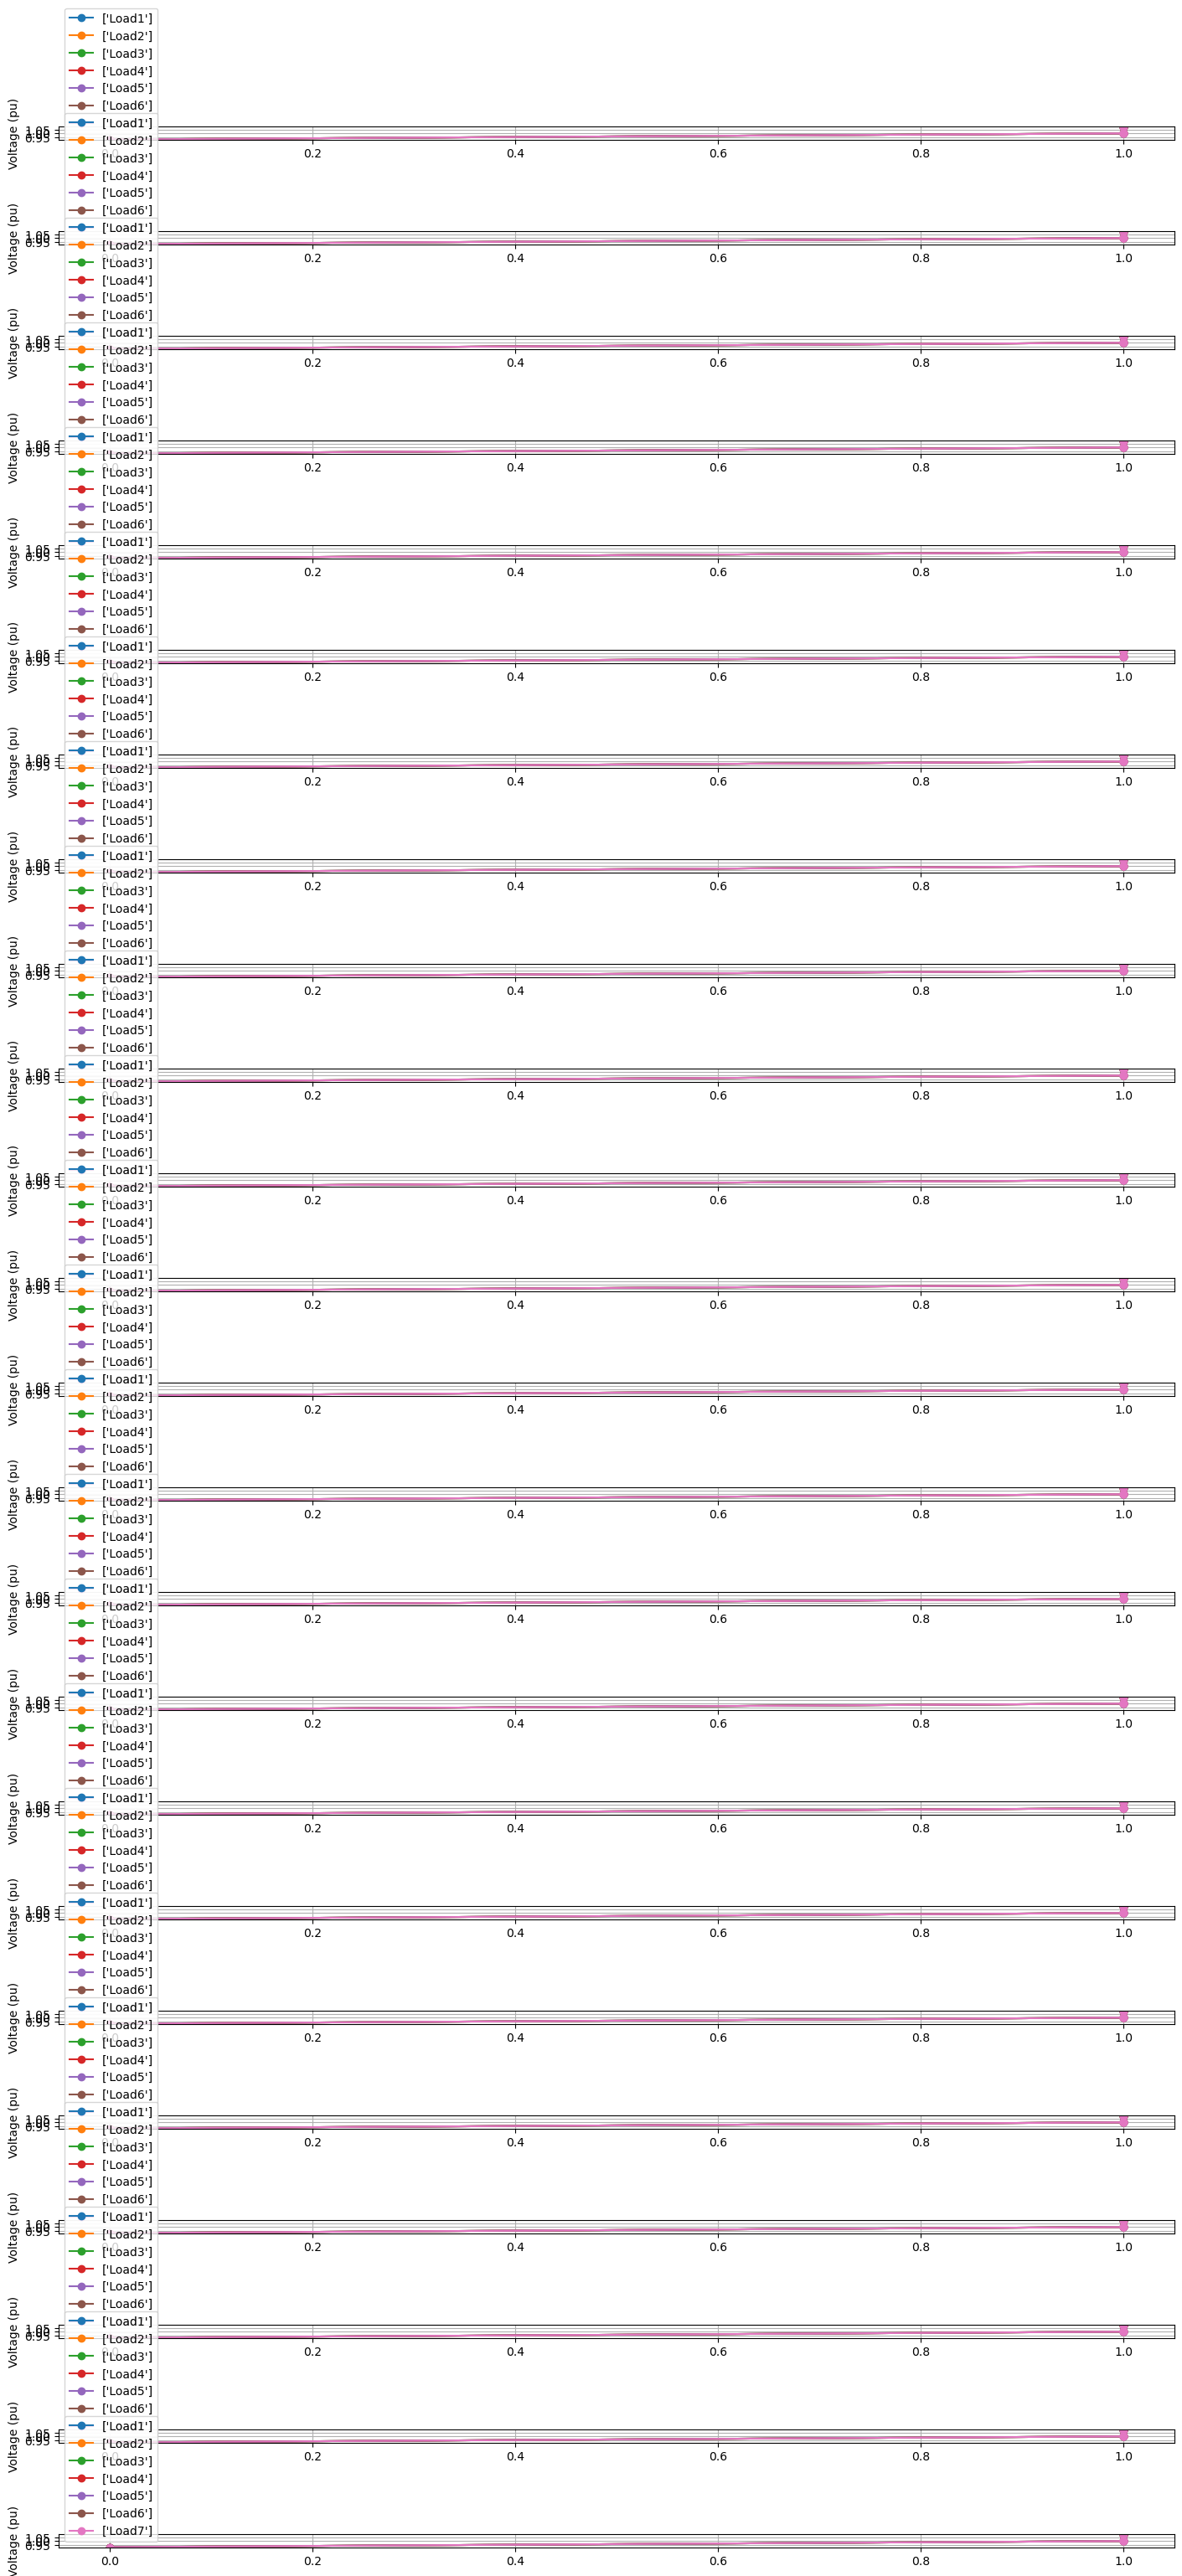

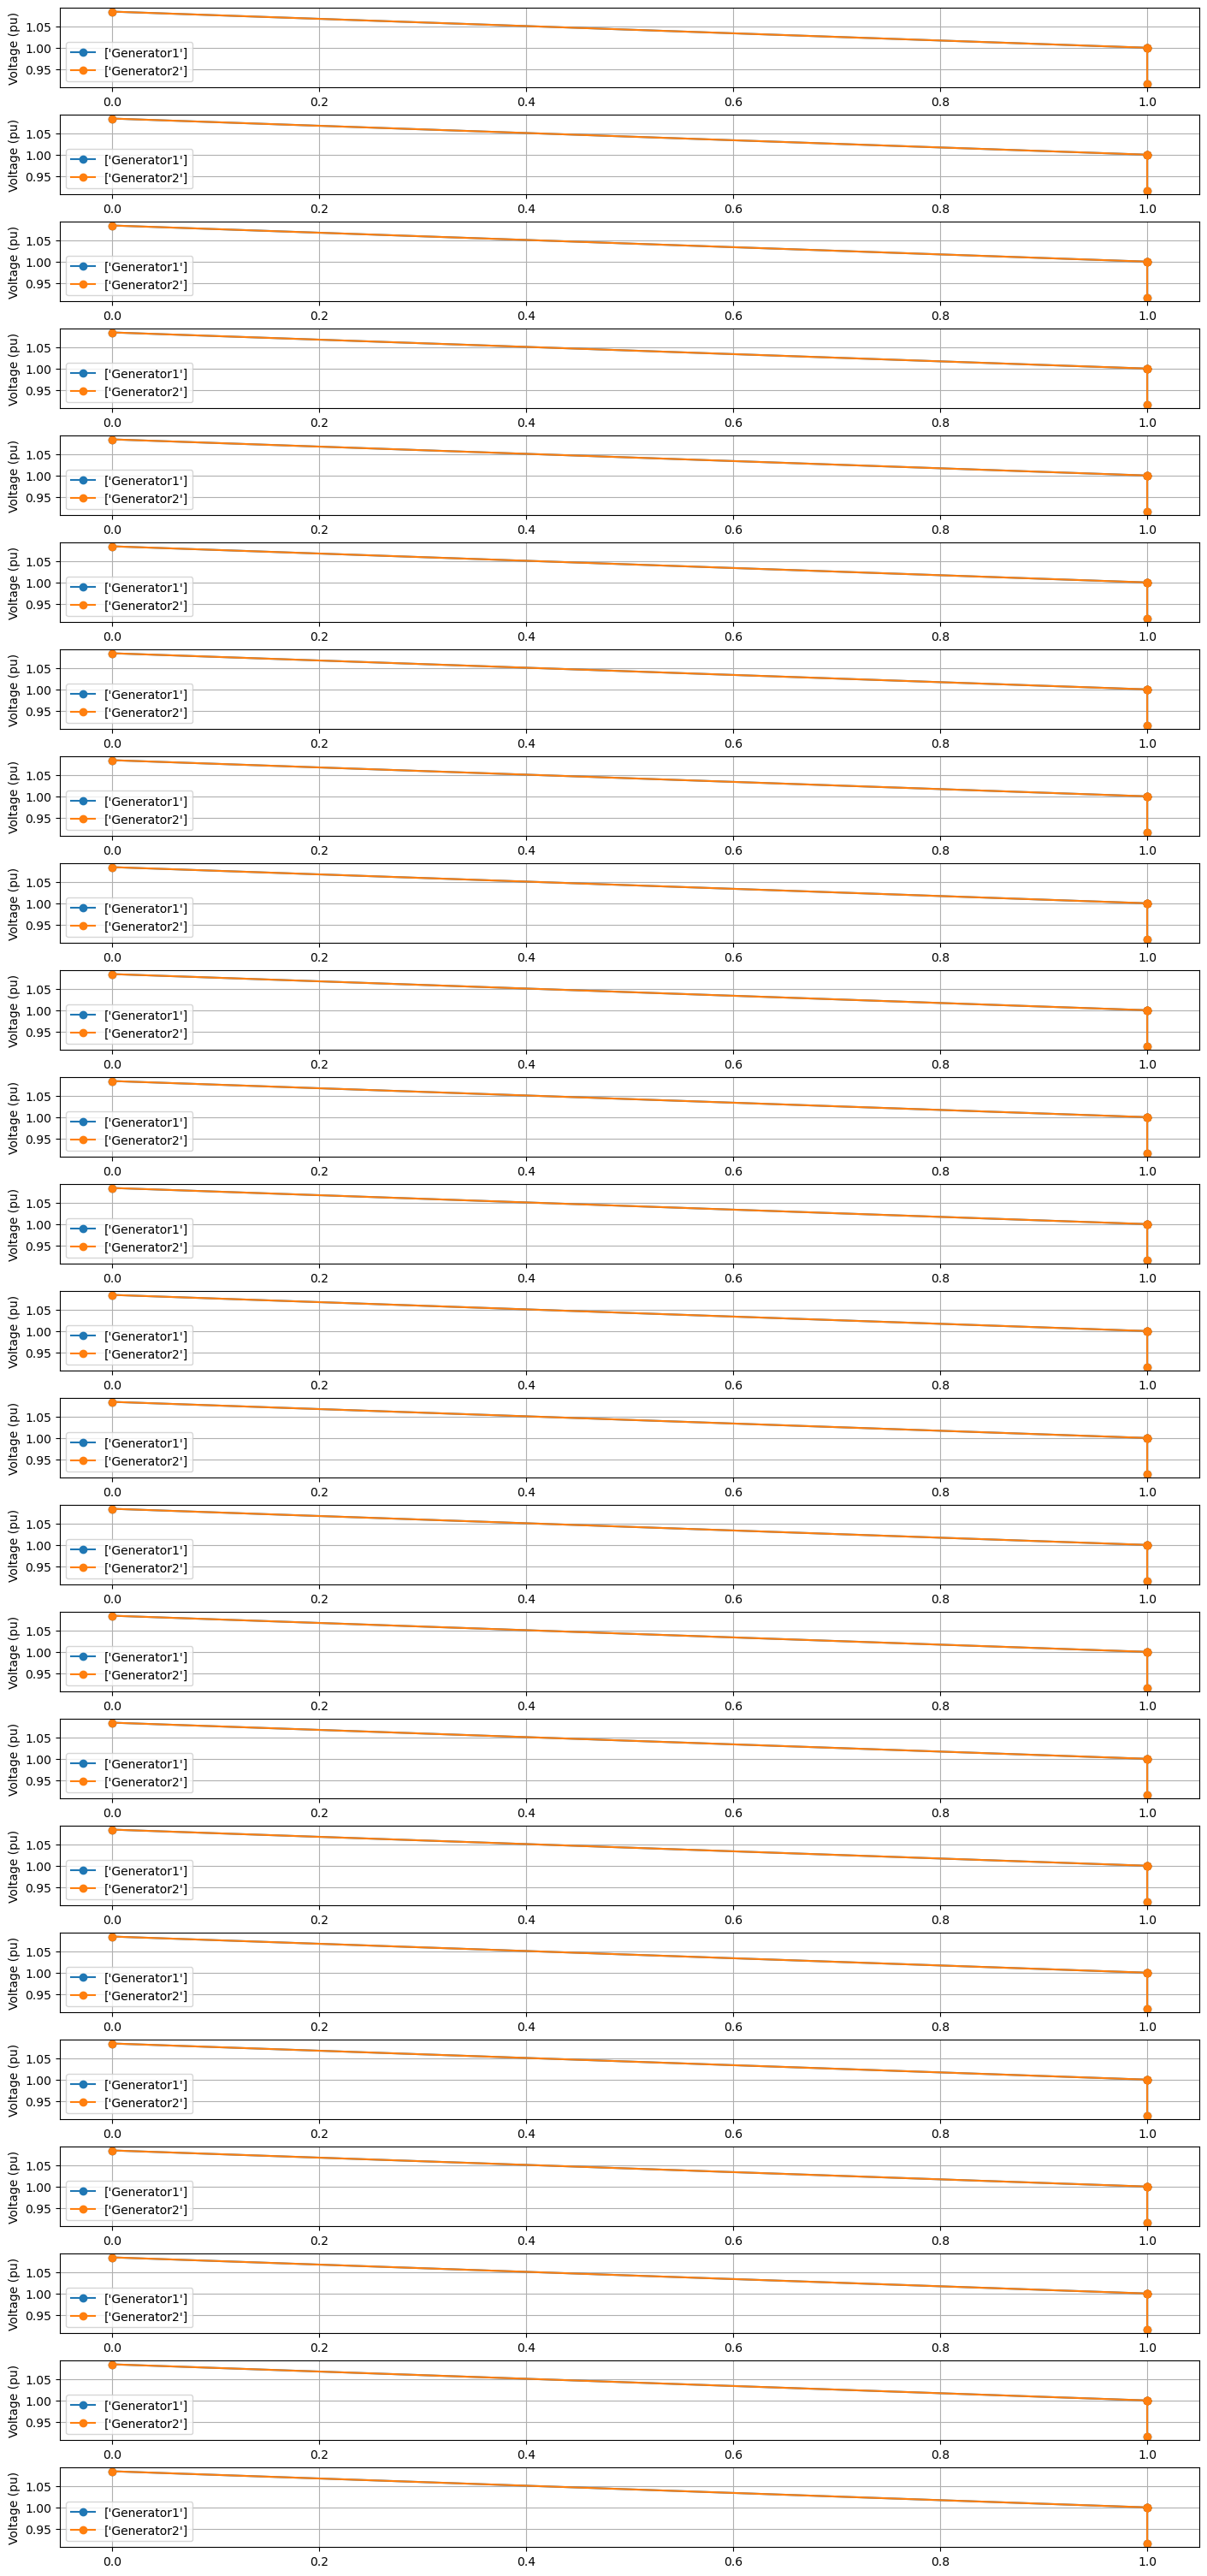

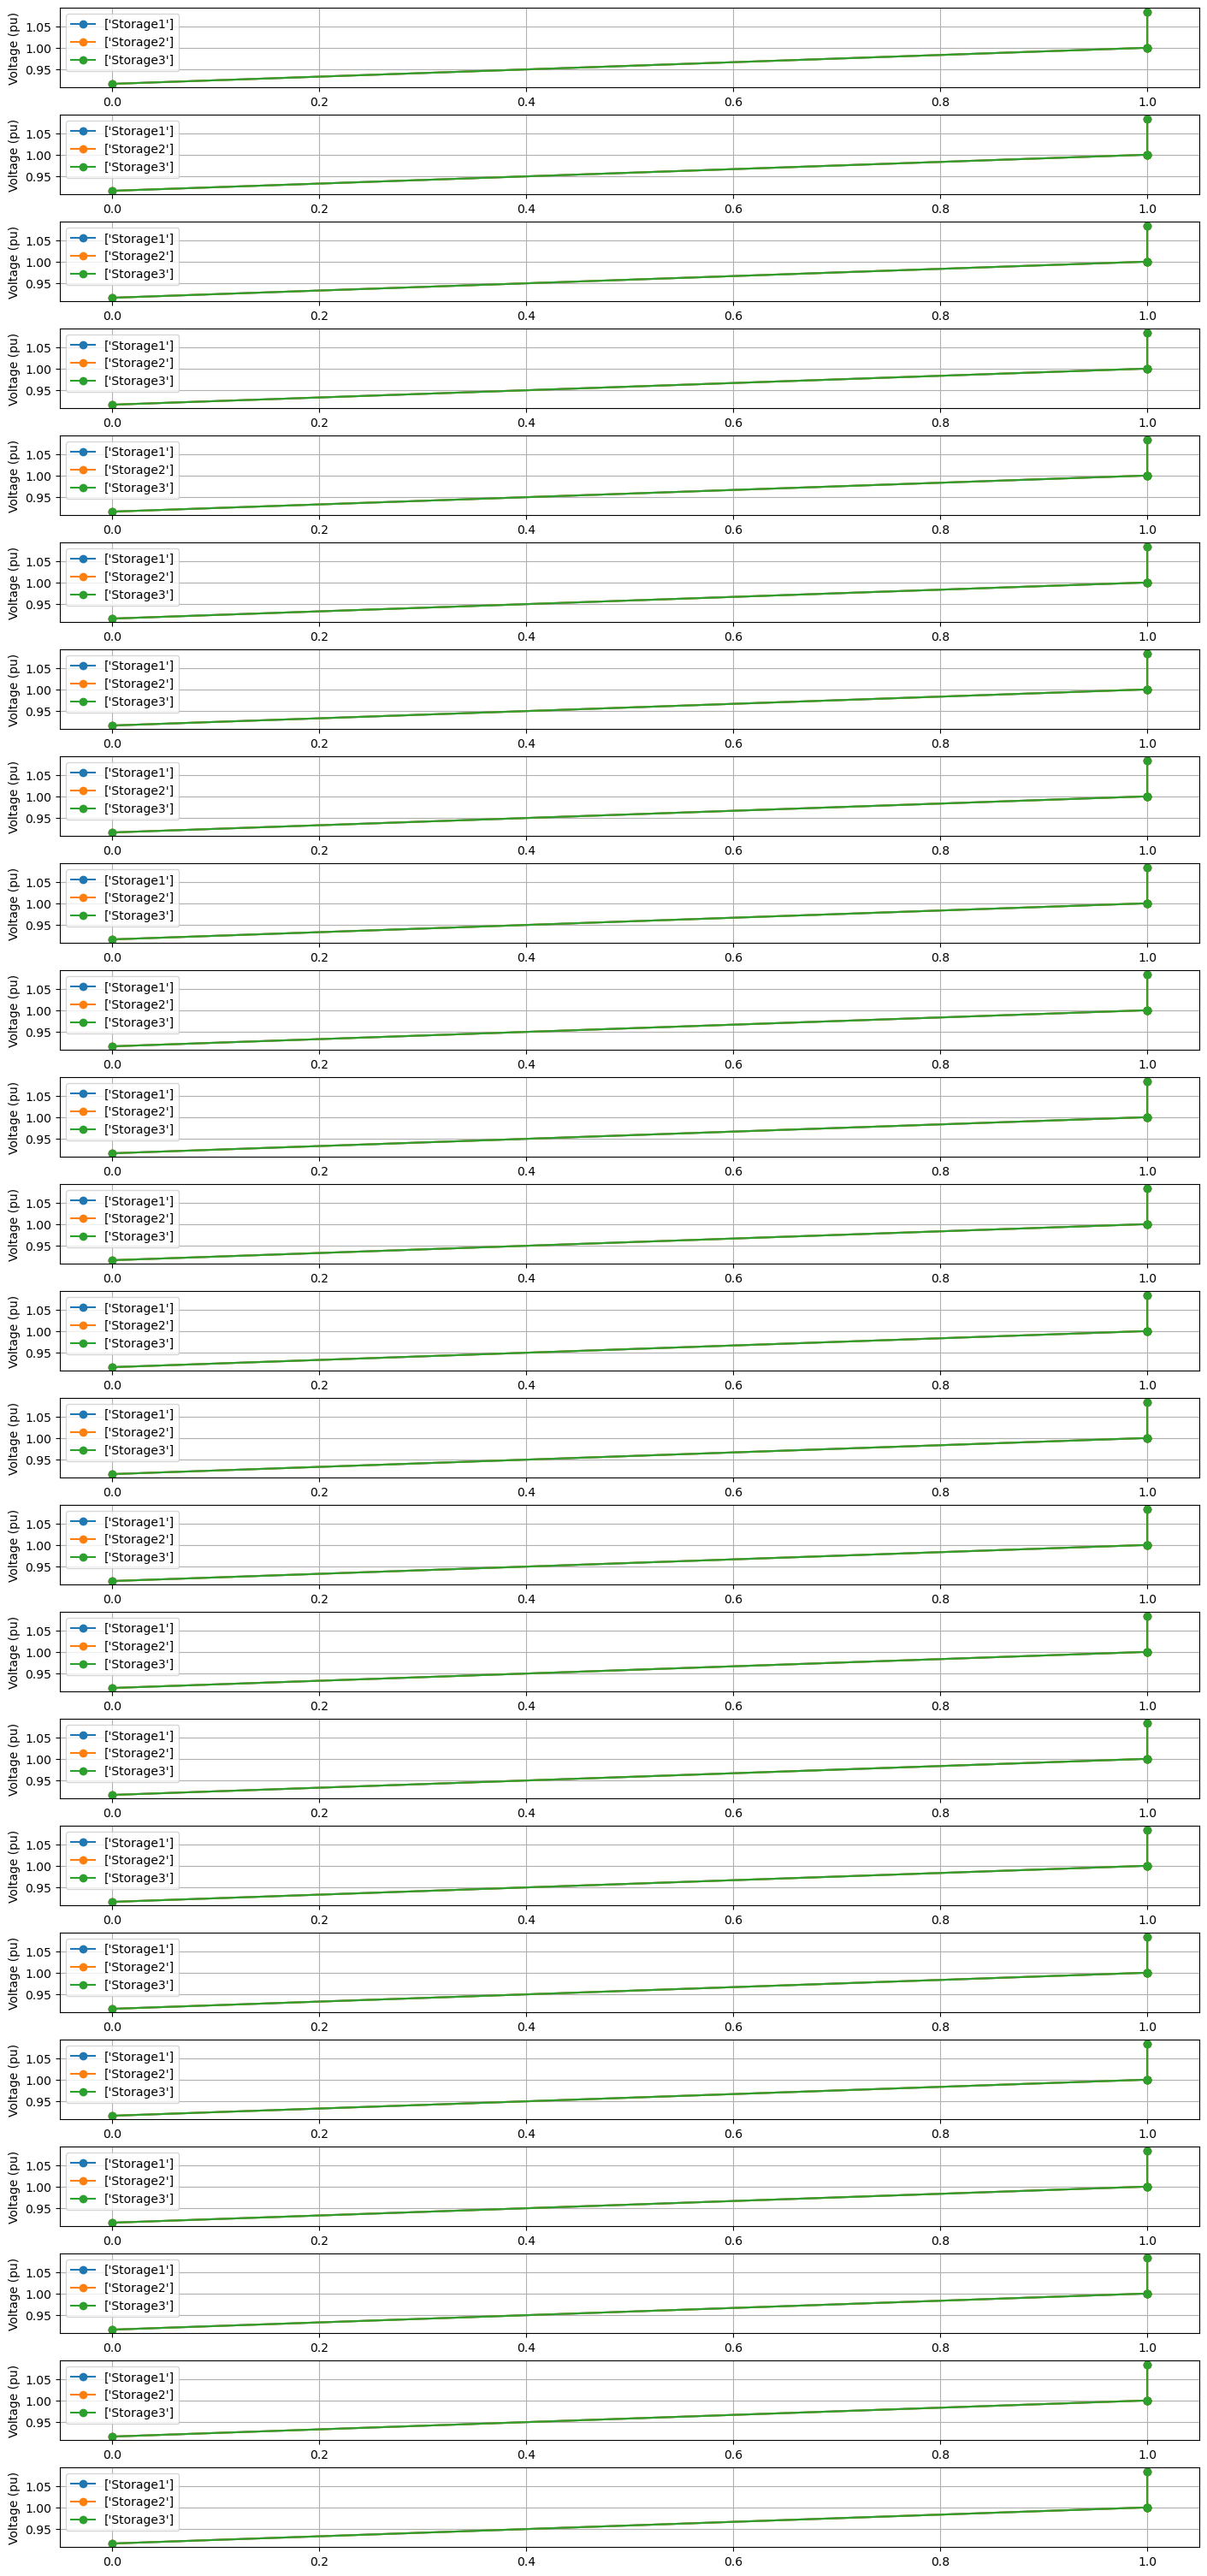

In [6]:
# Plotting the droop curves of each load and generator equipment 

def printDroopcurves(internal_netdata):

    # Unzip lists of data

    Loadlist = internal_netdata['Loadlist']
    Genlist = internal_netdata['Genlist']
    Storlist = internal_netdata['Storlist']

    # Load equipment

    time_list = [i for i in Loadlist[0].droop.columns if type(i) is int]

    fig, axs = plt.subplots(len(time_list),1,figsize=(14, 30),layout='constrained')
    #fig.title("Loads Droop Evolution")
    labels = []
    for i in range(0,len(time_list)):
        for j in range(0,len(Loadlist)):
            auxV = Loadlist[j].droop.index[Loadlist[j].droop['Droop'].str.contains('V')]
            auxP = Loadlist[j].droop.index[Loadlist[j].droop['Droop'].str.contains(r'P\d+', regex=True)]   
            axs[i].plot(Loadlist[j].droop.loc[auxP,time_list[i]].values,Loadlist[j].droop.loc[auxV,time_list[i]].values, marker='o', linestyle='-')     
            labels.append(['Load' + str(Loadlist[j].load_id)])
        axs[i].set_ylabel("Voltage (pu)")
        axs[i].legend(labels)
        axs[i].grid(True)
        
    plt.show()

    # Generator equipment

    fig, axs = plt.subplots(len(time_list),1,figsize=(14, 30),layout='constrained')
    #fig.title("Generators Droop Evolution")
    labels = []
    for i in range(0,len(time_list)):
        for j in range(0,len(Genlist)):
            auxV = Genlist[j].droop.index[Genlist[j].droop['Droop'].str.contains('V')]
            auxP = Genlist[j].droop.index[Genlist[j].droop['Droop'].str.contains(r'P\d+', regex=True)]   
            axs[i].plot(Genlist[j].droop.loc[auxP,time_list[i]].values,Genlist[j].droop.loc[auxV,time_list[i]].values, marker='o', linestyle='-')     
            labels.append(['Generator' + str(Genlist[j].gen_id)])
        axs[i].set_ylabel("Voltage (pu)")
        axs[i].legend(labels)
        axs[i].grid(True)
        
    plt.show()



    # Storage equipment

    fig, axs = plt.subplots(len(time_list),1,figsize=(14, 30),layout='constrained')
    #fig.title("Droop Evolution")
    labels = []
    for i in range(0,len(time_list)):
        for j in range(0,len(Storlist)):
            auxV = Storlist[j].droop.index[Storlist[j].droop['Droop'].str.contains('V')]
            auxP = Storlist[j].droop.index[Storlist[j].droop['Droop'].str.contains(r'P\d+', regex=True)]   
            axs[i].plot(Storlist[j].droop.loc[auxP,time_list[i]].values,Storlist[j].droop.loc[auxV,time_list[i]].values, marker='o', linestyle='-')     
            labels.append(['Storage' + str(Storlist[j].stor_id)])
        axs[i].set_ylabel("Voltage (pu)")
        axs[i].legend(labels)
        axs[i].grid(True)
        

    plt.show()

printDroopcurves(internal_netdata)

In [8]:
# Selection of Time-Variant or Steady-State PF

# Asking to user which are the time instants to perform the computations

def timeQuest(tl): # This function allows to give the pretended time series that the user want to study

    tl_chosen = []

    PF_type = input('\nWhat type of Power Flow Analysis is pretended to make? For Time-Dependent, type TD, for Steady-State, type SS, to exit, EXIT')

    if PF_type == 'TD':
        tl_chosen = tl.copy()

    elif PF_type == 'SS':
        
        print('\nThe list of time instants that is present in the Excel is given by',tl) # Print the time data for user choose the time instant that want to study 
        usInput = input('\nWhat is the time(s) instant(s) that the user want to study?') # Receive the hourly data from user (for exemple [1,2,...] or 1 2 ...) and treat that data
        print(usInput)
        if len(usInput) > 1:
            aux_usInput = [tl[x] for x in range(0,len(tl)) if usInput in tl[x]]
        else:
            aux_usInput = usInput
        tl_chosen.append(aux_usInput)

    elif PF_type == 'EXIT':
        print('Exit...')
        sys.exit()

    else:
        print('\nCaution! The value introduced is not according to the expected input.')
        return timeQuest(tl)

    return tl_chosen

## Functions to perform readjusment of loads, generators and storage power in Pandapower

def loaddroopReadjustment(AC_net, DC_net, Loadlist, Nodelist, AC_bus_voltages, DC_bus_voltages, base_power, aux_Matrixp, T, t):
    
    # Iterates in each load to obtain power point of operation

    for i, load in enumerate(Loadlist): 
    
        # Finding the indexes for the droop voltage and powers points as setpoints of power
    
        auxV = load.droop.index[load.droop['Droop'].str.contains('V')]
        auxP = load.droop.index[load.droop['Droop'].str.contains(r'P\d+', regex=True)]
        auxPS = load.droop.index[load.droop['Droop'].str.contains(r'P[A-Za-z]+', regex=True)]
        auxQS = load.droop.index[load.droop['Droop'].str.contains(r'Q[A-Za-z]+', regex=True)]

        # Identifies the type of electric grid (AC or DC) of the load

        aux_electype = next((node.elec_type for node in Nodelist if node.node_number.item() == load.bus), None)

        if aux_electype == 'AC':
            loadIdx = AC_net.load.index[AC_net.load['name'].isin([load.load_id])].astype(int)
        elif aux_electype == 'DC':
            loadIdx = DC_net.load.index[DC_net.load['name'].isin([load.load_id])].astype(int)

        # Reajustment of load power acording to specs of droop 

        if aux_electype == 'DC':
            if load.dp_cont == 1:  # Droop control activated
                pdroop = np.interp(DC_bus_voltages[load.bus].item(), load.droop.loc[auxV, T].values, load.droop.loc[auxP, T].values)
                pset = load.droop.loc[auxPS, T].values.item()

                # Verification if setpoint is higher than droop value
                pload = min(pdroop, pset) if abs(pset) < abs(pdroop) else pdroop
                DC_net.load.loc[loadIdx, 'p_mw'] = pload * load.pn / 1000  # Actualization of power in pandapower information
            elif load.dp_cont == 0:  # Without droop activated
                DC_net.load.loc[loadIdx, 'p_mw'] = load.droop.loc[auxPS, T].values.item() * load.pn / 1000

        elif aux_electype == 'AC':
            AC_net.load.loc[loadIdx, 'p_mw'] = load.droop.loc[auxPS, T].values.item() * load.pn / 1000
            AC_net.load.loc[loadIdx, 'q_mvar'] = load.droop.loc[auxQS, T].values.item() * load.pn / 1000

        # Atualization of the printing matrix aux_Matrixp
        if aux_electype == 'AC':
            aux_Matrixp[i, t] = AC_net.load.loc[loadIdx, 'p_mw'].item() * (1000 / base_power.item())
        elif aux_electype == 'DC':
            aux_Matrixp[i, t] = DC_net.load.loc[loadIdx, 'p_mw'].item() * (1000 / base_power.item())

    return AC_net, DC_net, aux_Matrixp

def gendroopReadjustment(AC_net, DC_net, Genlist, Nodelist, AC_bus_voltages, DC_bus_voltages, slack_comp, base_power, T):
    for i, gen in enumerate(Genlist):
        
        # Finding the indexes for the droop voltage and powers points as setpoints of power

        auxV = gen.droop.index[gen.droop['Droop'].str.contains('V')]
        auxP = gen.droop.index[gen.droop['Droop'].str.contains(r'P\d+', regex=True)]
        auxPS = gen.droop.index[gen.droop['Droop'].str.contains(r'P[A-Za-z]+', regex=True)]
        auxQS = gen.droop.index[gen.droop['Droop'].str.contains(r'Q[A-Za-z]+', regex=True)]

        # Identifies the type of electric grid (AC or DC) of the generator

        aux_electype = next((node.elec_type for node in Nodelist if node.node_number.item() == gen.bus), None)

        if aux_electype == 'AC':
            if gen.gen_id == slack_comp:
                genIdx = AC_net.gen.index[AC_net.gen['name'].isin([gen.gen_id])].astype(int)
            else:
                genIdx = AC_net.sgen.index[AC_net.sgen['name'].isin([gen.gen_id])].astype(int)
        elif aux_electype == 'DC':
            if gen.gen_id == slack_comp:
                genIdx = DC_net.gen.index[DC_net.gen['name'].isin([gen.gen_id])].astype(int)
            else:
                genIdx = DC_net.sgen.index[DC_net.sgen['name'].isin([gen.gen_id])].astype(int)

        # Reajustment of generator power acording to specs of droop 

        if aux_electype == 'DC':
            if gen.dp_cont == 1:  
         
                pdroop = np.interp(DC_bus_voltages[gen.bus].item(), gen.droop.loc[auxV, T].values, gen.droop.loc[auxP, T].values)
                pset = gen.droop.loc[auxPS, T].values.item()

                pgen = min(pdroop, pset) if abs(pset) > abs(pdroop) else pdroop

                target_net = DC_net.gen if gen.gen_id == slack_comp.values else DC_net.sgen
                target_net.loc[genIdx, 'p_mw'] = pgen * gen.pn / 1000

            else:  
                target_net = DC_net.gen if gen.gen_id == slack_comp else DC_net.sgen
                target_net.loc[genIdx, 'p_mw'] = gen.droop.loc[auxPS, T].values.item() * gen.pn / 1000


        elif aux_electype == 'AC':

            target_net = AC_net.gen
            target_net.loc[genIdx, 'p_mw'] = gen.droop.loc[auxPS, T].values.item() * gen.pn / 1000
            target_net.loc[genIdx, 'q_mvar'] = gen.droop.loc[auxQS, T].values.item() * gen.pn / 1000

    return AC_net, DC_net

def storControl(AC_net, DC_net, Storlist, Nodelist, AC_bus_voltages, DC_bus_voltages, base_power, period_duration, aux_Matrixsoc, T, t, erro, tol_max_perc): 

    def calculate_SOC(S_stor, period_duration, max_ener, ini_SOC, is_positive):
        """Calcula o SOC com base no valor da potência aparente."""
        SOC_change = ((S_stor * period_duration.item()) / (max_ener / 1e3)) * 100
        return SOC_change + ini_SOC if is_positive else ini_SOC - SOC_change

    def update_storage_power(net, storIdx, SOC_max_var, period_duration, max_ener):
        """Atualiza a potência no armazenamento para não exceder os limites de SOC."""
        net.storage.loc[storIdx, 'p_mw'] = (SOC_max_var / 100) * (max_ener / 1000) / period_duration.item()

    for i, stor in enumerate(Storlist):

        # Finding the indexes for the droop voltage and powers points as setpoints of power

        auxV = stor.droop.index[stor.droop['Droop'].str.contains('V')]
        auxP = stor.droop.index[stor.droop['Droop'].str.contains(r'P\d+', regex=True)]
        auxPS = stor.droop.index[stor.droop['Droop'].str.contains(r'P[A-Za-z]+', regex=True)]
        auxQS = stor.droop.index[stor.droop['Droop'].str.contains(r'Q[A-Za-z]+', regex=True)]

        # Identifies the type of electric grid (AC or DC) of the storage

        aux_electype = next((node.elec_type for node in Nodelist if node.node_number.item() == stor.bus), None)

        if aux_electype == 'AC':    
            storIdx = AC_net.storage.index[AC_net.storage['name'].isin([stor.stor_id])].astype(int)
        elif aux_electype == 'DC':
            storIdx = DC_net.storage.index[DC_net.storage['name'].isin([stor.stor_id])].astype(int)

        # Reajustment of generator power acording to specs of droop 

        if aux_electype == 'DC':
            if stor.dp_cont == 1:  

                pdroop = np.interp(DC_bus_voltages[buses[stor.bus]].item(), stor.droop.loc[auxV, T].values, stor.droop.loc[auxP, T].values)
                pset = stor.droop.loc[auxPS, T].item()
                pstor = min(pdroop, pset) if abs(pset) < abs(pdroop) else pdroop
                DC_net.storage.loc[storIdx, 'p_mw'] = pstor * stor.pn / 1000
            
            elif stor.dp_cont == 0:
            
                DC_net.storage.loc[storIdx, 'p_mw'] = stor.droop.loc[auxPS, T].item() * stor.pn / 1000
            
            P_stor = DC_net.storage.loc[storIdx, 'p_mw'].item()
            Q_stor = 0

        elif aux_electype == 'AC':
            AC_net.storage.loc[storIdx, 'p_mw'] = stor.droop.loc[auxPS, T].item() * stor.pn / 1000
            AC_net.storage.loc[storIdx, 'q_mvar'] = stor.droop.loc[auxQS, T].item() * stor.pn / 1000
            P_stor = AC_net.storage.loc[storIdx, 'p_mw'].item()
            Q_stor = AC_net.storage.loc[storIdx, 'q_mvar'].item()

        # Computation of absolute value of apparent power 
        S_stor = mt.sqrt(P_stor**2 + Q_stor**2)

        # SOC computation
        is_positive = P_stor > 0
        SOC_f = calculate_SOC(S_stor, period_duration, stor.max_ener, stor.ini_SOC, is_positive)

        # Verification of the limits of SOC
        if SOC_f < stor.min_SOC: 
            SOC_max_var = stor.ini_SOC - stor.min_SOC
            update_storage_power(DC_net if aux_electype == 'DC' else AC_net, storIdx, SOC_max_var, period_duration, stor.max_ener)
            SOC_f = stor.ini_SOC + SOC_max_var
        elif SOC_f > stor.max_SOC: 
            SOC_max_var = stor.max_SOC - stor.ini_SOC
            update_storage_power(DC_net if aux_electype == 'DC' else AC_net, storIdx, SOC_max_var, period_duration, stor.max_ener)
            SOC_f = stor.ini_SOC + SOC_max_var

        # Verification of the error, for SOC atualization
        if erro < tol_max_perc:
            stor.ini_SOC = SOC_f
            if aux_electype == 'DC':
                DC_net.storage.loc[storIdx, 'soc_percent'] = stor.ini_SOC
            elif aux_electype == 'AC':
                AC_net.storage.loc[storIdx, 'soc_percent'] = stor.ini_SOC

        # Atualization of the printing matrix of SOC
        aux_Matrixsoc[i, t] = stor.ini_SOC

    return AC_net, DC_net, aux_Matrixsoc


def convEst(AC_net, DC_net, Nodelist, Convlist, AC_bus_voltages, DC_bus_voltages, bus_voltages_angles, base_power, tol_max_perc):

    # Function to estimate the point of efficiency

    def effest(Pout, FPOut, aux_PF, aux_PO, aux_eff):
        points = [(fp, p) for fp in aux_PF for p in aux_PO]
        values = aux_eff.values.flatten()
        eff = griddata(points, values, (FPOut, Pout), method='linear')
        return eff if not np.isnan(eff) else 1.0

    for i, conv in enumerate(Convlist):

        # Finding the indexes of each pandapower element of converter model and each output and input networks

        conv_trafo_Idx = (AC_net.trafo.index[AC_net.trafo['name'].isin(['Converter ' + str(conv.conv_id)])].astype(int)
            if not AC_net.trafo[AC_net.trafo['name'].isin(['Converter ' + str(conv.conv_id)])].empty 
            else DC_net.trafo.index[DC_net.trafo['name'].isin(['Converter ' + str(conv.conv_id)])].astype(int))

        conv_sgen_Idx = (AC_net.sgen.index[AC_net.sgen['name'].isin(['Converter ' + str(conv.conv_id)])].astype(int)
            if not AC_net.sgen[AC_net.sgen['name'].isin(['Converter ' + str(conv.conv_id)])].empty 
            else DC_net.sgen.index[DC_net.sgen['name'].isin(['Converter ' + str(conv.conv_id)])].astype(int))

        conv_vs_Idx = (AC_net.ext_grid.index[AC_net.ext_grid['name'].isin(['Converter ' + str(conv.conv_id)])].astype(int)
            if not AC_net.ext_grid[AC_net.ext_grid['name'].isin(['Converter ' + str(conv.conv_id)])].empty 
            else DC_net.ext_grid.index[DC_net.ext_grid['name'].isin(['Converter ' + str(conv.conv_id)])].astype(int))

        conv_line_Idx = (AC_net.line.index[AC_net.line['name'].isin(['Converter ' + str(conv.conv_id)])].astype(int)
            if not AC_net.line[AC_net.line['name'].isin(['Converter ' + str(conv.conv_id)])].empty 
            else DC_net.line.index[DC_net.line['name'].isin(['Converter ' + str(conv.conv_id)])].astype(int))

        Input_net = (AC_net 
                    if not AC_net.trafo[AC_net.trafo['name'].isin(['Converter ' + str(conv.conv_id)])].empty 
                    else DC_net)

        Output_net = (AC_net 
                    if not AC_net.line[AC_net.line['name'].isin(['Converter ' + str(conv.conv_id)])].empty 
                    else DC_net)

        desl_conv_Idx = None

        # Finding the índexes of the buses of internal dataset (Nodelist)

        aux_fbus_idx, aux_tbus_idx = None, None

        for j, node in enumerate(Nodelist):
            if node.node_number.item() == conv.from_bus:
                aux_fbus_idx = j
                aux_electype_fbus = node.elec_type
            if node.node_number.item() == conv.to_bus:
                aux_tbus_idx = j
                aux_electype_tbus = node.elec_type

        # Converter model computation
        
        k = 1e-3

        # Verification of first iteration 

        Input_voltages = Input_net.res_bus.vm_pu.values

        if Input_voltages.size == 0:

            # Initial values of first running
 
            Psgen = 0                                                                   # Active power value of static generator
            Qsgen = 0                                                                   # Reactive power value of static generator
            internal_volt = 1                                                           # Voltage value of external grid

        else:

            # Previous parameters values from last running
 
            #
            #Xline = k*Rline                                                                # Reactance value 
            Psgen = Input_net.sgen.loc[conv_sgen_Idx,'p_mw'].item()                         # Active power value of static generator
            Qsgen = 0                                                                       # Reactive power value of static generator (Improvement: Include PCC power factor correction if PCC is AC)
            internal_volt = 1                                                               # Voltage value of external grid (Improvement: Include voltage control)
            #Rtrafo = Input_net.trafo.loc[conv_trafo_Idx,'vkr_percent']                     # Resistance value of isolator transformer
            #Xtrafo = mt.sqrt(Input_net.trafo.loc[conv_trafo_Idx,'vk_percent']**2 - Rtrafo**2)/(Input_net.trafo.loc[conv_trafo_Idx,'vn_lv_kv']**2/(base_power.item() / 1e3))       # Reactance value of isolator transformer

            # Results values from last running

            Pin = -Input_net.res_trafo.loc[conv_trafo_Idx,'p_lv_mw'].item()/(base_power.item()/1e3)
            Pout = Output_net.res_line.loc[conv_line_Idx,'p_from_mw'].item()/(base_power.item()/1e3)
            
            if abs(Pout)==0 and np.isnan(Pin) or np.isnan(Pout): # Turning off the converter

                Psgen = 0
                
                pass
            
            else:
                
                # Computation of the point of efficiency for the converter

                if abs(Pin) > abs(Pout):

                    Pout_conv = abs(Pout)
                    if mt.sqrt(Output_net.res_line.loc[conv_line_Idx,'p_from_mw'].item()**2+Output_net.res_line.loc[conv_line_Idx,'q_from_mvar'].item()**2)!=0:
                        FPout = abs(Output_net.res_line.loc[conv_line_Idx,'p_from_mw'].item())/mt.sqrt(Output_net.res_line.loc[conv_line_Idx,'p_from_mw'].item()**2+Output_net.res_line.loc[conv_line_Idx,'q_from_mvar'].item()**2)
                    else:
                        FPout = 1
                    Out_conv = 'Out'

                else:

                    Pout_conv = abs(Pin)
                    if mt.sqrt(Input_net.res_trafo.loc[conv_trafo_Idx,'p_lv_mw'].item()**2+Input_net.res_trafo.loc[conv_trafo_Idx,'q_lv_mvar'].item()**2):
                        FPout = abs(Input_net.res_trafo.loc[conv_trafo_Idx,'p_lv_mw'].item())/mt.sqrt(Input_net.res_trafo.loc[conv_trafo_Idx,'p_lv_mw'].item()**2+Input_net.res_trafo.loc[conv_trafo_Idx,'q_lv_mvar'].item()**2)
                    else:
                        FPout = 1
                    Out_conv = 'In'


                eff_actual = effest(Pout_conv*(base_power.item()/conv.pn), FPout, conv.eff_table['Efficiency Curve'].dropna().unique(),
                                conv.eff_table.columns[conv.eff_table.columns.get_loc('Efficiency Curve') + 1:].values,
                                conv.eff_table.iloc[:, conv.eff_table.columns.get_loc('Efficiency Curve') + 1:])

                # Verification of the operation of the converter


                if Out_conv == 'Out':

                    Psgen = Pout/eff_actual

                elif Out_conv == 'In':

                    Psgen = Pout/eff_actual

        # Verification of the type of control of converter

        if conv.control_mode == 'Voltage':

            Output_net.ext_grid.loc[conv_vs_Idx, 'vm_pu'] = conv.control_value

        elif conv.control_mode == 'Power':

            Output_net.ext_grid.loc[conv_vs_Idx, 'vm_pu'] = conv.control_value * Input_net.res_trafo.loc[conv_trafo_Idx, 'vm_lv_pu'].item() # Modulation Index

        # Actualize the values of static generator
        
        Input_net.sgen.loc[conv_sgen_Idx, 'p_mw'] = Psgen * (base_power.item() / 1e3)

    return AC_net, DC_net, desl_conv_Idx

def conv_and_droop_verf(AC_net, DC_net, AC_bus_voltages, DC_bus_voltages, AC_bus_voltages_angles, erro, tol_max_perc, aux_Matrixp, aux_Matrixsoc, T, t, internal_netdata):

    # Unzip lists of data
    Nodelist = internal_netdata['Nodelist']
    Linelist = internal_netdata['Linelist']
    Trafolist = internal_netdata['Trafolist']
    Convlist = internal_netdata['Convlist']
    Loadlist = internal_netdata['Loadlist']
    Genlist = internal_netdata['Genlist']
    Storlist = internal_netdata['Storlist']
    base_power = internal_netdata['general_data']['base_power']
    period_duration = internal_netdata['general_data']['period_duration']
    slack_comp = internal_netdata['general_data']['slack_comp'].item()

    AC_net, DC_net, desl_conv_Idx = convEst(AC_net, DC_net, Nodelist, Convlist, AC_bus_voltages, 
                                          DC_bus_voltages, AC_bus_voltages_angles, base_power, tol_max_perc)
                
    AC_net, DC_net, aux_Matrixp = loaddroopReadjustment(AC_net, DC_net, Loadlist, Nodelist, 
                                                                     AC_bus_voltages, DC_bus_voltages, 
                                                                     base_power, aux_Matrixp, T, t)
    AC_net, DC_net = gendroopReadjustment(AC_net, DC_net, Genlist, Nodelist, AC_bus_voltages, 
                                                      DC_bus_voltages, slack_comp, base_power, T)
    AC_net, DC_net, aux_Matrixsoc = storControl(AC_net, DC_net, Storlist, Nodelist, AC_bus_voltages, 
                                                            DC_bus_voltages, base_power, period_duration, 
                                                            aux_Matrixsoc, T, t, erro, tol_max_perc)

    return AC_net, DC_net, aux_Matrixp, aux_Matrixsoc


def runpptd_cusm(AC_net, DC_net, buses, internal_netdata):

    aux = internal_netdata['Loadlist']
    time_list = [i for i in aux[0].droop.columns if isinstance(i, int)]
    del aux
    time_list_chosen = timeQuest(time_list)

    tol_max_perc = 1e-2  # Maximum tolerance in percentage
    n_iter_max = 35  # Maximum number of iterations assumed
    n_iter_PF = 10  # Maximum number of iteration of Pandapower PF
    erro = 1  # Error

    # Matrices to store voltage, power, and SOC data for each time step, separated by AC and DC
    AC_bus_voltages_old_print = []  # Will store matrices for each time step
    DC_bus_voltages_old_print = []
    load_p_old_print = []
    SOC_old_print = []

    # Auxiliary matrices for voltages, power and SOC
    aux = len(internal_netdata['Loadlist'])
    aux1 = len(internal_netdata['Storlist'])
    aux_Matrix_AC = np.ones([len(AC_net.bus), n_iter_max])  
    aux_Matrix_DC = np.ones([len(DC_net.bus), n_iter_max])  
    aux_Matrixp = np.ones([aux, n_iter_max])
    aux_Matrixsoc = np.ones([aux1, n_iter_max])
    del aux, aux1

    start_time_TD = tm.time()

    # Generate timestamp for the results filename
    timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

    # Define the result folder path (same directory as the script)
    result_folder_path = os.path.join(os.getcwd(), 'PF Results')
    
    # Ensure the directory exists
    if not os.path.exists(result_folder_path):
        os.makedirs(result_folder_path)

    # Define the output CSV file path
    output_file = os.path.join(result_folder_path, f"PF_results_{timestamp}.csv")

    # Initialize aux_forloop to False before the loop
    aux_forloop = False

    with open(output_file, 'w') as f:
        # Write header to the file
        f.write("Time Step,AC_Bus_Voltages,DC_Bus_Voltages,Load_Power,SOC\n")

        for T in time_list_chosen:
            T = int(T)
            #print(f">Run power flow analysis - Time Step {T}")

            repetir = True  
            t = 0  

            # Initialize voltage and power values for comparison
            aux = len(internal_netdata['Nodelist'])
            AC_bus_voltages_old = np.zeros(len(AC_net.bus))
            DC_bus_voltages_old = np.zeros(len(DC_net.bus))
            bus_power_injections_old = np.zeros(aux)
            del aux

            aux_Matrix_AC[:, t] = 1  
            aux_Matrix_DC[:, t] = 1  

            if not aux_forloop:

                AC_bus_voltages = np.ones(len(AC_net.bus))
                DC_bus_voltages = np.ones(len(DC_net.bus))
                AC_bus_voltages_angles = np.zeros(len(AC_net.bus))

                conv_and_droop_verf(AC_net, DC_net, AC_bus_voltages, DC_bus_voltages, AC_bus_voltages_angles, erro, tol_max_perc, aux_Matrixp, aux_Matrixsoc, T, t, internal_netdata)

                aux_forloop = True

            start_time = tm.time()

            while repetir:
                
                #### PF HYBRID COMPUTATION INCORPORATED INTO PP FUNCTIONS ####

                # Hybrid computation

                error = 10

                while error > tol_max_perc:

                    if not (T == time_list_chosen[0] and t == 0): 
                        
                        # Cross-products of jacobian (interation between AC and DC values)

                        cross_derivatives, V_updated = calculate_cross_derivatives(AC_net, DC_net, internal_netdata)
                    
                    # AC PF

                    try:
                        pp.runpp(AC_net, max_iteration=n_iter_PF)
                        #print(AC_net.res_bus)
                    except pp.LoadflowNotConverged:
                        print("AC Power Flow did not converge")
                        repetir = False

                    int_old_AC_volt = AC_net.res_bus.vm_pu.values

                    # DC PF

                    try:
                        #pp.rundcpp(DC_net, max_iteration=n_iter_PF)
                        pp.runpp(DC_net, max_iteration=n_iter_PF)
                        #print(DC_net.bus,DC_net.res_bus)
                    except pp.LoadflowNotConverged:
                        print("DC Power Flow did not converge")
                        repetir = False

                    if (T == time_list_chosen[0] and t == 0): 

                        # Cross-products of jacobian (interation between AC and DC values)

                        cross_derivatives, V_updated = calculate_cross_derivatives(AC_net, DC_net, internal_netdata)

                    # Error of Hybrid grid computation 

                    error = max(abs(AC_net.res_bus.vm_pu.values - int_old_AC_volt)/AC_net.res_bus.vm_pu.values)*100


                AC_bus_voltages = AC_net.res_bus.vm_pu.values
                AC_bus_voltages_angles = AC_net.res_bus.va_degree.values * (mt.pi / 180)
                DC_bus_voltages = DC_net.res_bus.vm_pu.values
                mask = ~DC_net['bus']['name'].str.contains('Converter')  
                bus_power_injections = np.concatenate((AC_net.res_bus.p_mw.values, DC_net.res_bus.p_mw[mask].reset_index(drop=True).values))
                
                if t == 0:
                    bus_power_injections_old = np.zeros(bus_power_injections.shape)

                # Error computation

                erro = compute_error(AC_bus_voltages, AC_bus_voltages_old, DC_bus_voltages, DC_bus_voltages_old, bus_power_injections, bus_power_injections_old)

                if erro < tol_max_perc and t != 0:
                    end_time = tm.time()
                    elapsed_time = end_time - start_time
                    repetir = False
                
                elif t >= n_iter_max:
                    print(f"Power Flow solution not obtained due to max iterations, error: {erro}% for time instant {T}")
                    repetir = False
                

                # Actualizing the last results

                AC_bus_voltages_old = AC_bus_voltages
                DC_bus_voltages_old = DC_bus_voltages
                bus_power_injections_old = bus_power_injections

                aux_Matrix_AC[:, t] = AC_bus_voltages  
                aux_Matrix_DC[:, t] = DC_bus_voltages  

                conv_and_droop_verf(AC_net, DC_net, AC_bus_voltages, DC_bus_voltages, AC_bus_voltages_angles, erro, tol_max_perc, aux_Matrixp, aux_Matrixsoc, T, t, internal_netdata)   # Just to print (if not repetir)

                if not repetir:

                    # Append results for each time step without overwriting
                    AC_bus_voltages_old_print.append(aux_Matrix_AC[:, :t].copy())  # Append the entire matrix values for the current time step
                    DC_bus_voltages_old_print.append(aux_Matrix_DC[:, :t].copy())
                    load_p_old_print.append(aux_Matrixp[:, :t].copy())
                    SOC_old_print.append(aux_Matrixsoc[:, :t].copy())
                
                else:

                    t += 1  


            # Write results for the current time step in the output file
            result_str = f"Time Step {T}\n"
            result_str += f"AC Bus Voltages: {AC_bus_voltages}\n"
            result_str += f"DC Bus Voltages: {DC_bus_voltages}\n"
            result_str += f"Bus Injections: {bus_power_injections}\n"
            result_str += f"SOC: {SOC_old_print[T-1]}\n"  # Writing SOC info from the list
            f.write(result_str)  # Write results to the file

        print(f"Saved results in: {output_file}")

    end_time_TD = tm.time()
    elapsed_time_TD = end_time_TD - start_time_TD
    print(f"Power Flow solution obtained in {elapsed_time_TD*1000} ms for time interval between {min(time_list_chosen)} and {max(time_list_chosen)}")

    # Using just one variable to return printing results
    internal_printing_results = {
        'Time_Steps': time_list_chosen,
        'AC_bus_voltages_old_print': AC_bus_voltages_old_print,
        'DC_bus_voltages_old_print': DC_bus_voltages_old_print,
        'load_p_old_print': load_p_old_print,
        'SOC_old_print': SOC_old_print
    }

    return AC_net, DC_net, internal_printing_results


# Helper function to compute the error deviation
def compute_error(AC_bus_voltages, AC_bus_voltages_old, DC_bus_voltages, DC_bus_voltages_old, bus_power_injections, bus_power_injections_old):
    AC_voltage_deviation = abs(AC_bus_voltages - AC_bus_voltages_old) / AC_bus_voltages
    DC_voltage_deviation = abs(DC_bus_voltages - DC_bus_voltages_old) / DC_bus_voltages
    power_inj_deviation = abs(bus_power_injections - bus_power_injections_old) / bus_power_injections

    max_deviation = max(np.concatenate((AC_voltage_deviation, DC_voltage_deviation, power_inj_deviation)))
    return max_deviation * 100  # Error in percentage

def calculate_cross_derivatives(net_ac, net_dc,internal_netdata):
    """
    Function to calculate the cross derivatives of converters missing in the Jacobian matrix for a hybrid AC/DC system.
    
    Arguments:
    - net_ac: AC network (pandapower dataframe)
    - net_dc: DC network (DC input data)
    
    Returns:
    - cross_derivatives: dPDC/dVAC (Jacobian matrix with cross derivatives)
    - updated_voltages: Updated AC voltage.
    """

    # Extract the list of converters
    Convlist = internal_netdata['Convlist']
    Nodelist = internal_netdata['Nodelist']
    base_power = internal_netdata['general_data']['base_power']

    for i, conv in enumerate(Convlist):
        
        if conv.convtype.__contains__('AC/DC'):

            # Values of voltages and currents in converter

            conv_trafo_Idx = (AC_net.trafo.index[AC_net.trafo['name'].isin(['Converter ' + str(conv.conv_id)])].astype(int)
                if not AC_net.trafo[AC_net.trafo['name'].isin(['Converter ' + str(conv.conv_id)])].empty 
                else DC_net.trafo.index[DC_net.trafo['name'].isin(['Converter ' + str(conv.conv_id)])].astype(int))

            conv_sgen_Idx = (AC_net.sgen.index[AC_net.sgen['name'].isin(['Converter ' + str(conv.conv_id)])].astype(int)
                if not AC_net.sgen[AC_net.sgen['name'].isin(['Converter ' + str(conv.conv_id)])].empty 
                else DC_net.sgen.index[DC_net.sgen['name'].isin(['Converter ' + str(conv.conv_id)])].astype(int))

            conv_vs_Idx = (AC_net.ext_grid.index[AC_net.ext_grid['name'].isin(['Converter ' + str(conv.conv_id)])].astype(int)
                if not AC_net.ext_grid[AC_net.ext_grid['name'].isin(['Converter ' + str(conv.conv_id)])].empty 
                else DC_net.ext_grid.index[DC_net.ext_grid['name'].isin(['Converter ' + str(conv.conv_id)])].astype(int))

            conv_line_Idx = (AC_net.line.index[AC_net.line['name'].isin(['Converter ' + str(conv.conv_id)])].astype(int)
                if not AC_net.line[AC_net.line['name'].isin(['Converter ' + str(conv.conv_id)])].empty 
                else DC_net.line.index[DC_net.line['name'].isin(['Converter ' + str(conv.conv_id)])].astype(int))

            Input_net = (AC_net 
                if not AC_net.trafo[AC_net.trafo['name'].isin(['Converter ' + str(conv.conv_id)])].empty 
                else DC_net)

            Output_net = (AC_net 
                        if not AC_net.line[AC_net.line['name'].isin(['Converter ' + str(conv.conv_id)])].empty 
                        else DC_net)

            for j, node in enumerate(Nodelist):
                if node.node_number.item() == conv.from_bus:
                    aux_fbus_idx = j
                    aux_electype_fbus = node.elec_type
                if node.node_number.item() == conv.to_bus:
                    aux_tbus_idx = j
                    aux_electype_tbus = node.elec_type

            if aux_electype_fbus == 'AC':

                Vo = Input_net.res_trafo.loc[conv_trafo_Idx,'vm_lv_pu'].item()

                Vi = Output_net.res_line.loc[conv_line_Idx,'vm_from_pu'].item()

                Ib = (base_power.item()/1e3)/(Vi*Output_net.bus.loc[Output_net.line.loc[conv_line_Idx,'from_bus'].item(),'vn_kv'].item())

                Iij = -Output_net.res_line.loc[conv_line_Idx,'i_from_ka'].item()/Ib

                Pi = -Output_net.res_line.loc[conv_line_Idx,'p_from_mw'].item()/(base_power.item()/1e3)

            elif aux_electype_tbus == 'AC':

                Vi = Input_net.res_trafo.loc[conv_trafo_Idx,'vm_lv_pu'].item()

                Vo = Output_net.res_line.loc[conv_line_Idx,'vm_from_pu'].item()

                Ib = (base_power.item()/1e3)/(Vi*Input_net.bus.loc[Input_net.trafo.loc[conv_trafo_Idx,'lv_bus'].item(),'vn_kv'].item())

                Iij = -Input_net.res_trafo.loc[conv_trafo_Idx,'i_lv_ka'].item()/Ib

                Pi = -Input_net.res_trafo.loc[conv_trafo_Idx,'p_lv_mw'].item()/(base_power.item()/1e3)

            else:

                pass

            # Obtaining the equivalent conductance value of the converter, cross-derivative computation and actualized values of voltages
            if (Vi - Vo) != 0:

                Geq = Iij/(Vi-Vo)

                cross_derivative = Vi * Geq

                if cross_derivative != 0:

                    Vo_updated = Vo + (-1/cross_derivative) * Pi

                else:

                    Vo_updated = Vo

            else:

                return 0, 1

            if aux_electype_fbus == 'AC':

                Input_net.res_trafo.loc[conv_trafo_Idx,'vm_lv_pu'] = Vo_updated 
                Input_net.res_bus.loc[Input_net.trafo.loc[conv_trafo_Idx,'lv_bus'].item(),'vm_pu'] = Vo_updated

            elif aux_electype_tbus == 'AC':

                Output_net.res_line.loc[conv_line_Idx,'vm_from_pu'] = Vo_updated
                Output_net.res_bus.loc[Output_net.line.loc[conv_line_Idx,'from_bus'].item(),'vm_pu'] = Vo_updated

            else:

                return


    return cross_derivative, Vo_updated

[AC_net, DC_net, internal_printing_results] = runpptd_cusm(AC_net,DC_net,buses,internal_netdata)



C:\Users\HP\AppData\Local\Temp\ipykernel_8664\69824205.py:595: RuntimeWarning:

invalid value encountered in divide

C:\Users\HP\AppData\Local\Temp\ipykernel_8664\69824205.py:595: RuntimeWarning:

invalid value encountered in divide

C:\Users\HP\AppData\Local\Temp\ipykernel_8664\69824205.py:595: RuntimeWarning:

invalid value encountered in divide

C:\Users\HP\AppData\Local\Temp\ipykernel_8664\69824205.py:595: RuntimeWarning:

invalid value encountered in divide

C:\Users\HP\AppData\Local\Temp\ipykernel_8664\69824205.py:595: RuntimeWarning:

invalid value encountered in divide

C:\Users\HP\AppData\Local\Temp\ipykernel_8664\69824205.py:595: RuntimeWarning:

divide by zero encountered in divide

C:\Users\HP\AppData\Local\Temp\ipykernel_8664\69824205.py:595: RuntimeWarning:

invalid value encountered in divide

C:\Users\HP\AppData\Local\Temp\ipykernel_8664\69824205.py:595: RuntimeWarning:

invalid value encountered in divide

C:\Users\HP\AppData\Local\Temp\ipykernel_8664\69824205.py:595: 

Saved results in: c:\Users\HP\Desktop\Engenharia Eletrotécnica\Doutoramento\1º Ano\Tese\Modelação\Programa Principal\PF Results\PF_results_2025-02-10_20-54-49.csv
Power Flow solution obtained in 46464.19286727905 ms for time interval between 1 and 24


C:\Users\HP\AppData\Local\Temp\ipykernel_8664\69824205.py:595: RuntimeWarning:

invalid value encountered in divide



> Plotting profiles


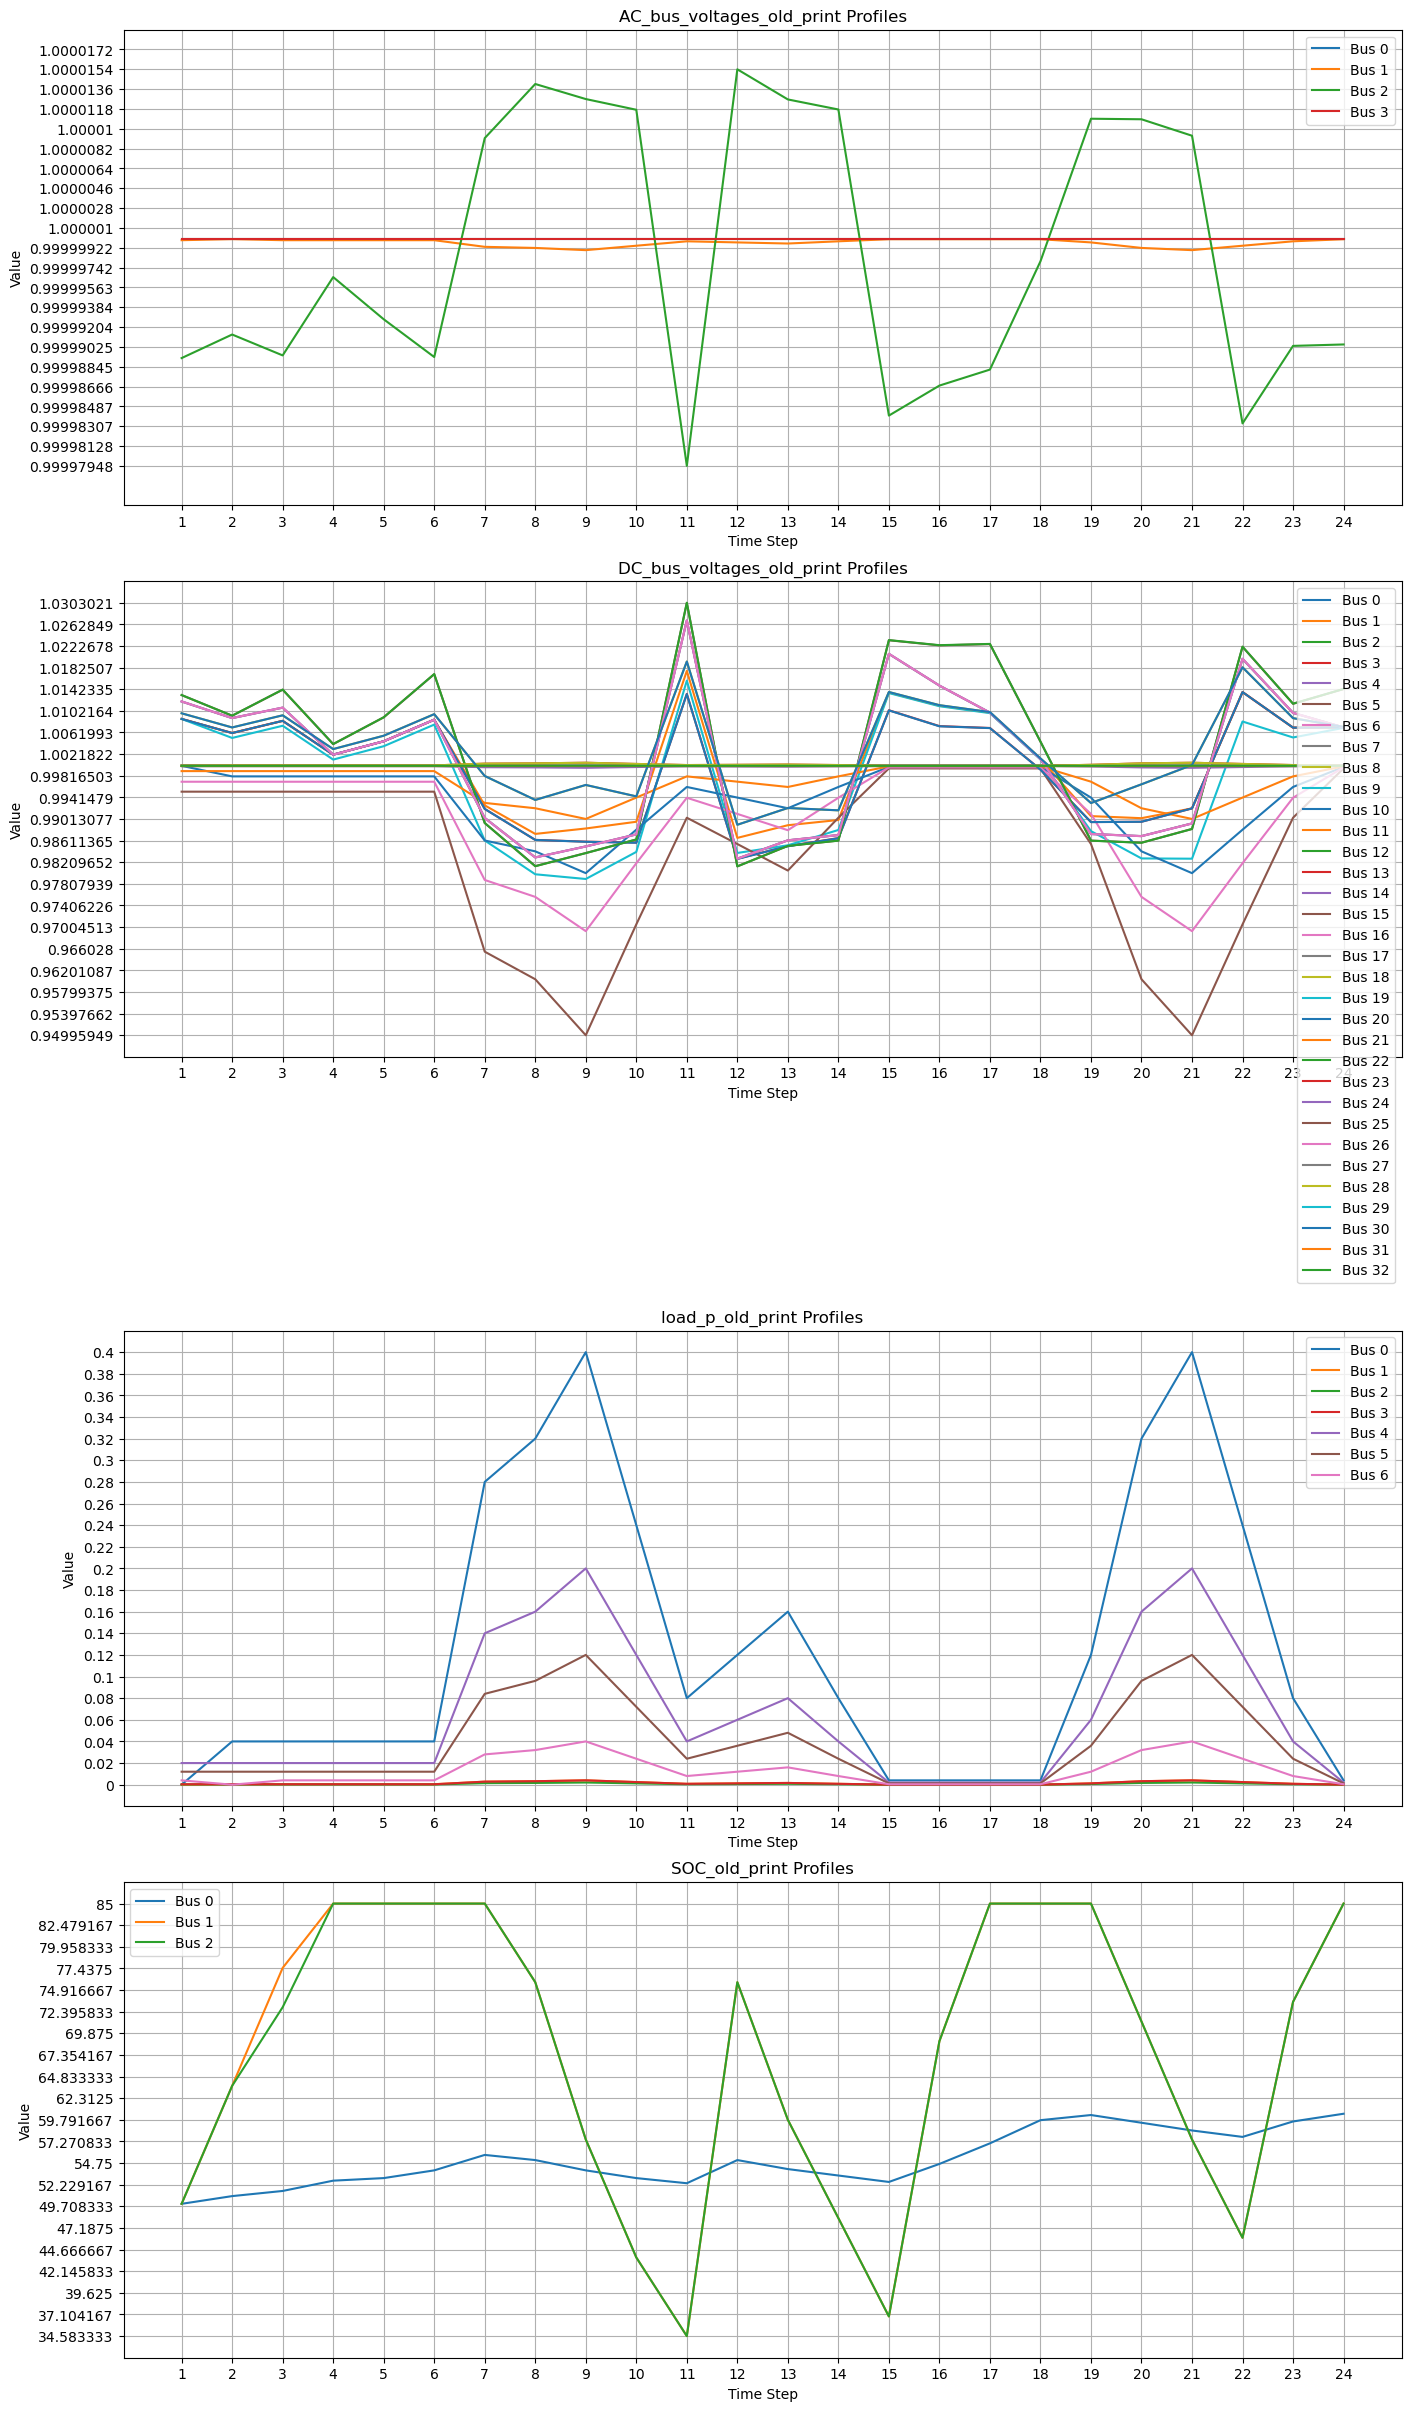

In [9]:

def plot_profiles(data_dict, ylabel='Value', save_to_file=False, filename='profiles.png'):
    print("> Plotting profiles")

    aux_data_dict = deepcopy(data_dict)

    # Ensure 'Time_Steps' is in the dictionary
    if 'Time_Steps' in aux_data_dict:
        time_steps = aux_data_dict.pop('Time_Steps')  # Get the time_steps values
    else:
        raise KeyError("The 'Time_Steps' key was not found in the dictionary!")

    # Check if the data_dict is not empty after removing 'Time_Steps'
    if not aux_data_dict:
        raise ValueError("The profiles dictionary is empty after removing 'Time_Steps'. Check the data.")

    num_subplots = len(aux_data_dict)  # Number of subplots to generate

    fig, axs = plt.subplots(num_subplots, 1, figsize=(14, 6 * num_subplots), constrained_layout=True)

    if num_subplots == 1:
        axs = [axs]  # If there's only one subplot, make sure axs is a list

    for ax, (var_name, data_list) in zip(axs, aux_data_dict.items()):
        num_buses = len(data_list[0])  # Number of buses in each variable

        ax.set_title(f"{var_name} Profiles")

        # Loop to plot data for each bus
        for i in range(num_buses):
            bus_values = [data_list[t][i, -1] for t in range(len(time_steps))]  # Get the bus values for time_steps
            ax.plot(time_steps, bus_values, label=f'Bus {i}')  # Use time_steps as the X-axis values

        ax.set_ylabel(ylabel)
        ax.set_xlabel("Time Step")
        ax.grid(True)
        ax.legend(loc='best')

        # Calculate Y-axis limits dynamically
        all_values = np.concatenate([data[:, -1] for data in data_list])
       
        # Adjust the Y-axis limits to be more sensitive to variations
        min_value, max_value = np.min(all_values), np.max(all_values)

        # Dynamic adjustment with a more pronounced factor
        max_range_value = 1e3
        range_value = min(max_range_value, max_value - min_value)
        padding = 0.05 * range_value  # The padding value can be adjusted to control the expansion

        if range_value < 1e-3:  # If the variation is very small
            ax.set_ylim([min_value - padding * 2, max_value + padding * 2])  # More spacing
        else:
            ax.set_ylim([min_value - padding, max_value + padding])  # Normal spacing


        # Set X-axis ticks dynamically
        ax.set_xticks(time_steps)
        ax.set_xticklabels([f'{int(x)}' for x in time_steps])

        # Calculate the range of values for the Y-ticks
        tick_step = (max_value - min_value) / 20  # Dividing the range into 10 ticks
        ticks = np.arange(min_value, max_value + tick_step, tick_step)  # Create ticks array

        # Set the ticks manually on the Y-axis
        ax.set_yticks(ticks)

        # Set the tick labels with a specific precision
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.8g}'))  # Formatting the ticks

    plt.show()

    # Save the plot to a file if desired
    if save_to_file:
        fig.savefig(filename)
        print(f"Graph saved as {filename}")

    del aux_data_dict


plot_profiles(internal_printing_results)

In [ ]:
# Plot bus voltage evolution in iterations by each bus 

def printVoltIter(bus_voltages_old_print):
    print(">Plot bus voltages vs iterations evolution")

    if type(bus_voltages_old_print) is list:
        
        auxPrint = 0
        auxIdx = []
        
        for i in range(0,len(bus_voltages_old_print)):
            
            if bus_voltages_old_print[i].shape[1] > 1:
                
                auxPrint += 1
                auxIdx.append(i)


        fig, axs = plt.subplots(auxPrint,1,figsize=(14, 30),layout='constrained')
        title_names = []

        for i in range(0,auxPrint):
                
                axs[i].plot(bus_voltages_old_print[auxIdx[i]].transpose())
                title_names = ['Time Instant = ' + str(auxIdx[i] + 1)]
                axs[i].set_title(title_names)
                axs[i].set_ylabel("Voltage (pu)")
                axs[i].set_xlim(0, bus_voltages_old_print[auxIdx[i]].shape[1]-1)
                axs[i].set_xticks(range(1,bus_voltages_old_print[auxIdx[i]].shape[1]))
                axs[i].grid(True)
        
        plt.xlabel("Iterations")
        plt.show

    else:

        plt.plot(bus_voltages_old_print.transpose())
        plt.show

    return

def printPowerIter(load_p_old_print):
    
    print(">Plot power components vs iterations evolution")

    if type(load_p_old_print) is list:
        
        auxPrint = 0
        auxIdx = []
        
        for i in range(0,len(load_p_old_print)):
            
            if load_p_old_print[i].shape[1] > 1:
                
                auxPrint += 1
                auxIdx.append(i)


        fig, axs = plt.subplots(auxPrint,1,figsize=(14, 30),layout='constrained')
        title_names = []

        for i in range(0,auxPrint):
                
                axs[i].plot(load_p_old_print[auxIdx[i]].transpose())
                title_names = ['Time Instant = ' + str(auxIdx[i] + 1)]
                axs[i].set_title(title_names)
                axs[i].set_ylabel("Power (pu)")
                axs[i].set_xlim(0, load_p_old_print[auxIdx[i]].shape[1]-1)
                axs[i].set_xticks(range(1,load_p_old_print[auxIdx[i]].shape[1]))
                axs[i].grid(True)
        
        plt.xlabel("Iterations")
        plt.show

    else:

        plt.plot(load_p_old_print.transpose())
        plt.show

    return

def printSOCIter(SOC_old_print):
    
    print(">Plot SOC vs iterations evolution")

    if type(SOC_old_print) is list:
        
        auxPrint = 0
        auxIdx = []
        
        for i in range(0,len(SOC_old_print)):
            
            if SOC_old_print[i].shape[1] > 1:
                
                auxPrint += 1
                auxIdx.append(i)


        fig, axs = plt.subplots(auxPrint,1,figsize=(14, 30),layout='constrained')
        title_names = []

        for i in range(0,auxPrint):
                
                axs[i].plot(SOC_old_print[auxIdx[i]].transpose())
                title_names = ['Time Instant = ' + str(auxIdx[i] + 1)]
                axs[i].set_title(title_names)
                axs[i].set_ylabel("SOC (%)")
                axs[i].set_xlim(0, SOC_old_print[auxIdx[i]].shape[1]-1)
                axs[i].set_xticks(range(1,SOC_old_print[auxIdx[i]].shape[1]))
                axs[i].grid(True)
        
        plt.xlabel("Iterations")
        plt.show

    else:

        plt.plot(SOC_old_print.transpose())
        plt.show

    return

printVoltIter(AC_bus_voltages_old_print)

printPowerIter(load_p_old_print)

printSOCIter(SOC_old_print)

''' Code written that could help

fig, axs = plt.subplots(len(drp_idx_aux),1,figsize=(14, 30),layout='constrained')
#fig.title("Droop Evolution")
labels = []
for i,_ in enumerate(droop_data.Node_j):
    axs[i].plot(range(0,t), bus_voltages_old_print[:,i], marker='o', linestyle='-')
    labels = [net.bus['name'].iloc[int(drp_idx_aux[i])]+' - PF']
    axs[i].set_ylabel("Voltage (pu)")
    axs[i].legend(labels)
    axs[i].grid(True)
    axs[i].set_xlim(0, t)
    #axs[i].set_ylim(bus_voltages_old_print[t-1,i]*0.995, bus_voltages_old_print[t-1,i]*1.005)
    #plt.plot(range(1,t+1), volt_aux.values[i,:], marker='+', linestyle=':')    
    #labels.append([net.bus['name'].iloc[int(drp_idx_aux[i])]+' - Power Voltage Droop Curve'])
plt.xlabel("Iterations")

labels = []
#plt.ylim(0.925, 1.075)
plt.show()

print(">Plot droop evolution")

plt.figure(figsize=(14, 6))
plt.title("Droop Evolution")
labels = []
for i,_ in enumerate(droop_data.Node_j):
    plt.plot(load_p_old_print[:,i],bus_voltages_old_print[:,i], marker='o', linestyle='-')
    labels.append([net.bus['name'].iloc[int(drp_idx_aux[i])]+' - PF'])
    plt.plot(p_aux.values[i,:], volt_aux.values[i,:], marker='+', linestyle=':')    
    labels.append([net.bus['name'].iloc[int(drp_idx_aux[i])]+' - Power Voltage Droop Curve'])
plt.legend(labels)
plt.xlabel("Power (pu)")
plt.ylabel("Voltage (pu)")
plt.grid(True)
#plt.ylim(0.925, 1.075)
#plt.xlim(-0.05, 2.1)
# plt.xticks(bus_indices)
plt.show()

'''

c:\Users\HP\anaconda3\Lib\site-packages\executing\executing.py:713: DeprecationWarning:

ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead

c:\Users\HP\anaconda3\Lib\ast.py:587: DeprecationWarning:

Attribute s is deprecated and will be removed in Python 3.14; use value instead

c:\Users\HP\anaconda3\Lib\site-packages\executing\executing.py:713: DeprecationWarning:

ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead

c:\Users\HP\anaconda3\Lib\ast.py:587: DeprecationWarning:

Attribute s is deprecated and will be removed in Python 3.14; use value instead



NameError: name 'AC_bus_voltages_old_print' is not defined

In [ ]:
# Computation of Environmental KPIs

# PUE - Power Usage Effectiveness (by load component)

